# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 1000
    
    nodes_cnt = 300

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [6]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [7]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [8]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [10]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [11]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

#### Generate 10,000 for train

In [ ]:
nodes_cnt = setting.nodes_cnt

In [ ]:
train_dir = os.path.join(setting._data, "train", str(nodes_cnt))
if os.path.exists(train_dir):
    pass
else:
    os.makedirs(train_dir)

In [ ]:
for i in range(10000):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(train_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(train_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

#### Generate 100 for validation

In [ ]:
valid_dir = os.path.join(setting._data, "valid", str(nodes_cnt))
if os.path.exists(valid_dir):
    pass
else:
    os.makedirs(valid_dir)

In [ ]:
for i in range(100):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(valid_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(valid_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

## Read data

### Load test data

In [12]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [13]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [14]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [15]:
train_loader = to_dataloader(train, train_bet, batch=32)
valid_loader = to_dataloader(valid, valid_bet, batch=32)

In [ ]:
for batch in train_loader:
    print(batch.y)

In [16]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [17]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [18]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [19]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [20]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [21]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [22]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [23]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [24]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [25]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [26]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [27]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [28]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [29]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [30]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/313 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930921116052237, top 1 = 0.9061333333333459, top 5 = 0.9407133333333099, top 10 = 0.9364366666665773, kendal = 0.8296808408388613


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930913624875642, top 1 = 0.8900000000000002, top 5 = 0.9473333333333335, top 10 = 0.9330000000000004, kendal = 0.8280615384615386

Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915719136951, top 1 = 0.9396666666666699, top 5 = 0.9535199999999663, top 10 = 0.9511033333332418, kendal = 0.8274682343688746


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894754200666, top 1 = 0.9300000000000002, top 5 = 0.9553333333333335, top 10 = 0.9473333333333336, kendal = 0.8264066889632108

Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915694249876, top 1 = 0.9497000000000018, top 5 = 0.9609133333332993, top 10 = 0.9575633333332504, kendal = 0.8514101485807744


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890021615457, top 1 = 0.9400000000000002, top 5 = 0.96, top 10 = 0.9526666666666673, kendal = 0.8492548494983282

Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914693353714, top 1 = 0.9564000000000011, top 5 = 0.9644466666666324, top 10 = 0.9600633333332497, kendal = 0.8592735279119729


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089775254478, top 1 = 0.9466666666666669, top 5 = 0.9626666666666668, top 10 = 0.9546666666666674, kendal = 0.8572882943143812

Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915481701572, top 1 = 0.9598666666666675, top 5 = 0.966113333333299, top 10 = 0.9616033333332556, kendal = 0.8660020605922562


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882154851815, top 1 = 0.9533333333333336, top 5 = 0.9646666666666667, top 10 = 0.9563333333333341, kendal = 0.8642095875139353

Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091519365697, top 1 = 0.961966666666667, top 5 = 0.9672199999999662, top 10 = 0.9628366666665877, kendal = 0.8682206272499465


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890380914143, top 1 = 0.9533333333333336, top 5 = 0.9673333333333334, top 10 = 0.9570000000000006, kendal = 0.8666479375696764

Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914037101967, top 1 = 0.9640000000000002, top 5 = 0.9681733333332996, top 10 = 0.9636333333332548, kendal = 0.8677002154403577


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897579123766, top 1 = 0.9600000000000002, top 5 = 0.9700000000000002, top 10 = 0.9586666666666674, kendal = 0.8660031215161653

Epoch: 8


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914246138865, top 1 = 0.9651000000000002, top 5 = 0.9687466666666323, top 10 = 0.9642766666665897, kendal = 0.8676667419242285


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895163922124, top 1 = 0.9600000000000002, top 5 = 0.9706666666666668, top 10 = 0.9586666666666673, kendal = 0.865926421404682

Epoch: 9


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091369664164, top 1 = 0.9654333333333334, top 5 = 0.9694999999999669, top 10 = 0.9648099999999246, kendal = 0.8670549549833891


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893304821096, top 1 = 0.9666666666666669, top 5 = 0.9713333333333334, top 10 = 0.9596666666666674, kendal = 0.8648138238573025

Epoch: 10


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913322385013, top 1 = 0.966066666666667, top 5 = 0.969766666666634, top 10 = 0.9652433333332576, kendal = 0.8649507250026923


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886117032429, top 1 = 0.9666666666666669, top 5 = 0.972, top 10 = 0.9606666666666674, kendal = 0.8624954292084729

Epoch: 11


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091393789655, top 1 = 0.9667000000000002, top 5 = 0.9700733333332999, top 10 = 0.9656699999999236, kendal = 0.8630792680523764


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897207698092, top 1 = 0.9700000000000002, top 5 = 0.9713333333333334, top 10 = 0.9616666666666674, kendal = 0.8604044593088073

Epoch: 12


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913612872751, top 1 = 0.9668333333333335, top 5 = 0.970533333333299, top 10 = 0.9660466666665924, kendal = 0.8647056492840053


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880355971993, top 1 = 0.9700000000000002, top 5 = 0.9726666666666667, top 10 = 0.9620000000000007, kendal = 0.8623304347826088

Epoch: 13


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913573987616, top 1 = 0.9675333333333334, top 5 = 0.9707599999999653, top 10 = 0.9662799999999263, kendal = 0.8674531989288627


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889819655299, top 1 = 0.9700000000000002, top 5 = 0.9733333333333334, top 10 = 0.9620000000000007, kendal = 0.8651589743589745

Epoch: 14


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913559371363, top 1 = 0.9682, top 5 = 0.9712333333332983, top 10 = 0.9665733333332602, kendal = 0.869825515623672


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088297686995, top 1 = 0.9700000000000002, top 5 = 0.9726666666666667, top 10 = 0.963000000000001, kendal = 0.867573690078038

Epoch: 15


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912136157117, top 1 = 0.9685, top 5 = 0.9714799999999651, top 10 = 0.9670366666665957, kendal = 0.8682557407395705


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890930714162, top 1 = 0.9666666666666669, top 5 = 0.9740000000000001, top 10 = 0.9643333333333343, kendal = 0.8658648829431438

Epoch: 16


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914600496423, top 1 = 0.9689333333333335, top 5 = 0.9717533333332982, top 10 = 0.9671833333332627, kendal = 0.868167559870894


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886137009411, top 1 = 0.9700000000000002, top 5 = 0.9753333333333333, top 10 = 0.9636666666666674, kendal = 0.8658216276477145

Epoch: 17


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091361729905, top 1 = 0.9691000000000004, top 5 = 0.9719999999999651, top 10 = 0.9673699999999297, kendal = 0.8684969065362298


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893464051486, top 1 = 0.9733333333333336, top 5 = 0.9753333333333333, top 10 = 0.964333333333334, kendal = 0.8661600891861763

Epoch: 18


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914099378187, top 1 = 0.9696000000000004, top 5 = 0.9721533333332986, top 10 = 0.9676299999999306, kendal = 0.8714719023189776


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886664943778, top 1 = 0.9733333333333336, top 5 = 0.9746666666666667, top 10 = 0.9666666666666675, kendal = 0.8692289855072463

Epoch: 19


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912445526712, top 1 = 0.9700666666666667, top 5 = 0.9723666666666321, top 10 = 0.9677733333332641, kendal = 0.8720477363704784


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888972263175, top 1 = 0.9733333333333336, top 5 = 0.9746666666666667, top 10 = 0.9660000000000006, kendal = 0.8698332218506131

Epoch: 20


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913952283042, top 1 = 0.9701333333333336, top 5 = 0.9726733333332986, top 10 = 0.9679333333332645, kendal = 0.872341083089643


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891553650024, top 1 = 0.9733333333333336, top 5 = 0.9760000000000001, top 10 = 0.9670000000000006, kendal = 0.8701123745819398

Epoch: 21


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914149202625, top 1 = 0.9704000000000004, top 5 = 0.9729133333332984, top 10 = 0.9681066666665978, kendal = 0.8758994430491979


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905149537372, top 1 = 0.9733333333333336, top 5 = 0.9760000000000001, top 10 = 0.9673333333333339, kendal = 0.8741721293199554

Epoch: 22


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913283381942, top 1 = 0.9705000000000004, top 5 = 0.9730666666666319, top 10 = 0.9681799999999304, kendal = 0.87712115547109


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905332253785, top 1 = 0.976666666666667, top 5 = 0.9760000000000001, top 10 = 0.9673333333333339, kendal = 0.8755464882943141

Epoch: 23


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914319698538, top 1 = 0.970666666666667, top 5 = 0.9731533333332986, top 10 = 0.9682433333332628, kendal = 0.8784528120859139


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930907757423986, top 1 = 0.9733333333333336, top 5 = 0.9753333333333335, top 10 = 0.968333333333334, kendal = 0.8769636566332218

Epoch: 24


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914341615385, top 1 = 0.9709333333333338, top 5 = 0.9732666666666324, top 10 = 0.9681533333332616, kendal = 0.8793468168751714


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902576275533, top 1 = 0.9700000000000002, top 5 = 0.974666666666667, top 10 = 0.9686666666666673, kendal = 0.8776526198439243

Epoch: 25


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915546716829, top 1 = 0.9714000000000002, top 5 = 0.9733333333332992, top 10 = 0.9682366666665939, kendal = 0.8817833807076955


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884929539739, top 1 = 0.976666666666667, top 5 = 0.9753333333333336, top 10 = 0.9680000000000006, kendal = 0.8803389074693422

Epoch: 26


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913626531868, top 1 = 0.9711333333333337, top 5 = 0.9734733333333002, top 10 = 0.9682966666665946, kendal = 0.8807569112302855


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887852929613, top 1 = 0.976666666666667, top 5 = 0.9766666666666669, top 10 = 0.9686666666666675, kendal = 0.8786867335562987

Epoch: 27


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913302726216, top 1 = 0.9712666666666672, top 5 = 0.9736466666666335, top 10 = 0.9685099999999276, kendal = 0.8822224343927645


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930876442695576, top 1 = 0.9733333333333336, top 5 = 0.9760000000000002, top 10 = 0.9683333333333342, kendal = 0.880497658862876

Epoch: 28


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913299604775, top 1 = 0.9715333333333336, top 5 = 0.9736866666666337, top 10 = 0.9686033333332634, kendal = 0.8832714447047483


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880035940803, top 1 = 0.9733333333333336, top 5 = 0.9773333333333335, top 10 = 0.9680000000000009, kendal = 0.8816410256410259

Epoch: 29


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913578017351, top 1 = 0.9718333333333334, top 5 = 0.9739399999999677, top 10 = 0.9687299999999306, kendal = 0.8833229016334734


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888050921353, top 1 = 0.9733333333333336, top 5 = 0.9773333333333335, top 10 = 0.9673333333333342, kendal = 0.8817047937569679

Epoch: 30


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912635251427, top 1 = 0.9717, top 5 = 0.9741133333333005, top 10 = 0.9685633333332642, kendal = 0.8845528667022785


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895044840101, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9676666666666676, kendal = 0.8831955406911933

Epoch: 31


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914459269281, top 1 = 0.9719333333333334, top 5 = 0.9741533333333009, top 10 = 0.9686599999999309, kendal = 0.8840350086687647


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903805701937, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9683333333333342, kendal = 0.8824584169453736

Epoch: 32


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912591326909, top 1 = 0.9723333333333332, top 5 = 0.9742466666666345, top 10 = 0.9689166666665967, kendal = 0.8839749185107848


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904839098347, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9683333333333342, kendal = 0.882319732441472

Epoch: 33


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913307030684, top 1 = 0.9723333333333336, top 5 = 0.9742733333333014, top 10 = 0.9687999999999313, kendal = 0.8855197964913807


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896714838242, top 1 = 0.976666666666667, top 5 = 0.9773333333333335, top 10 = 0.9686666666666675, kendal = 0.8843380156075809

Epoch: 34


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913797577221, top 1 = 0.9726000000000004, top 5 = 0.9743466666666345, top 10 = 0.9690099999999311, kendal = 0.8855069893317359


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897003114252, top 1 = 0.976666666666667, top 5 = 0.9773333333333335, top 10 = 0.9686666666666675, kendal = 0.884005797101449

Epoch: 35


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091514925793, top 1 = 0.9729000000000002, top 5 = 0.974379999999969, top 10 = 0.9687833333332628, kendal = 0.8860839381906502


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088618644825, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9690000000000007, kendal = 0.884773690078038

Epoch: 36


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913449633226, top 1 = 0.9730333333333337, top 5 = 0.9746066666666353, top 10 = 0.968896666666597, kendal = 0.8853266440061287


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890568433514, top 1 = 0.9700000000000002, top 5 = 0.9773333333333335, top 10 = 0.968333333333334, kendal = 0.8836490523968785

Epoch: 37


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914700170723, top 1 = 0.9732000000000005, top 5 = 0.9745933333333018, top 10 = 0.9689433333332643, kendal = 0.8872986921012218


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885267882161, top 1 = 0.9666666666666669, top 5 = 0.9766666666666669, top 10 = 0.968333333333334, kendal = 0.8861712374581937

Epoch: 38


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913805667744, top 1 = 0.9733666666666669, top 5 = 0.9747533333333027, top 10 = 0.969033333333263, kendal = 0.8871058680814764


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088437746098, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9686666666666673, kendal = 0.8858064659977706

Epoch: 39


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913313198042, top 1 = 0.9733000000000002, top 5 = 0.9746333333333023, top 10 = 0.9691099999999284, kendal = 0.8876392728076838


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902233799252, top 1 = 0.9666666666666669, top 5 = 0.9760000000000002, top 10 = 0.9690000000000007, kendal = 0.8862987736900783

Epoch: 40


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913063623257, top 1 = 0.9734333333333336, top 5 = 0.9748266666666355, top 10 = 0.9691366666665959, kendal = 0.8873001398717166


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902500202296, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9686666666666673, kendal = 0.885788182831661

Epoch: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913765487592, top 1 = 0.9735333333333338, top 5 = 0.9747399999999689, top 10 = 0.969246666666596, kendal = 0.8878973215811943


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888659422267, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9696666666666673, kendal = 0.8864040133779266

Epoch: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915131090313, top 1 = 0.9735666666666671, top 5 = 0.974873333333303, top 10 = 0.9692666666665959, kendal = 0.8886087641885355


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891496575968, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9690000000000006, kendal = 0.8873186176142697

Epoch: 43


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913151844458, top 1 = 0.9734333333333341, top 5 = 0.9747266666666359, top 10 = 0.9692099999999287, kendal = 0.8886300851345286


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089192825859, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9680000000000006, kendal = 0.8872628762541808

Epoch: 44


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912978708464, top 1 = 0.9734666666666675, top 5 = 0.9747866666666357, top 10 = 0.9692433333332634, kendal = 0.8888650263391024


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894475565436, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9690000000000007, kendal = 0.8876829431438127

Epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914185151131, top 1 = 0.9737000000000007, top 5 = 0.9748266666666358, top 10 = 0.9693033333332635, kendal = 0.8891078599520551


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089654945452, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9680000000000006, kendal = 0.887896989966555

Epoch: 46


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913345664186, top 1 = 0.9736666666666677, top 5 = 0.9748333333333022, top 10 = 0.9694466666665963, kendal = 0.8891084857905526


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886122645502, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9683333333333342, kendal = 0.8877369007803791

Epoch: 47


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913450328272, top 1 = 0.9740333333333341, top 5 = 0.9748466666666357, top 10 = 0.9694566666665966, kendal = 0.8897213053215787


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894224051086, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9680000000000006, kendal = 0.8885270903010034

Epoch: 48


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913962240778, top 1 = 0.9738666666666675, top 5 = 0.9748799999999688, top 10 = 0.9694899999999302, kendal = 0.8898326998388971


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930864410864795, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9690000000000007, kendal = 0.8888410256410255

Epoch: 49


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912089317426, top 1 = 0.9740333333333341, top 5 = 0.9749399999999693, top 10 = 0.9695633333332636, kendal = 0.8896976140095965


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892305169636, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9690000000000007, kendal = 0.8883812709030097

Epoch: 50


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913448862174, top 1 = 0.9738666666666675, top 5 = 0.9749199999999688, top 10 = 0.9695733333332639, kendal = 0.8905396137384549


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090232831954, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9690000000000007, kendal = 0.8894028985507247

Epoch: 51


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914247096005, top 1 = 0.9740333333333343, top 5 = 0.9749333333333019, top 10 = 0.96964999999993, kendal = 0.89041516682569


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899016316384, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9686666666666675, kendal = 0.8891125975473801

Epoch: 52


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913900956199, top 1 = 0.9738666666666677, top 5 = 0.9749999999999687, top 10 = 0.9697066666665977, kendal = 0.8900563975867603


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930876963802559, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9686666666666673, kendal = 0.8886006688963214

Epoch: 53


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914230656019, top 1 = 0.9740666666666675, top 5 = 0.9750133333333022, top 10 = 0.9695766666665966, kendal = 0.8909562539196184


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897375820477, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.968333333333334, kendal = 0.889911259754738

Epoch: 54


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091217684689, top 1 = 0.9741333333333343, top 5 = 0.9752199999999686, top 10 = 0.969769999999931, kendal = 0.8906828333526496


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901654167326, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9680000000000006, kendal = 0.8895491638795987

Epoch: 55


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091412762157, top 1 = 0.9743666666666674, top 5 = 0.975186666666635, top 10 = 0.9697566666665965, kendal = 0.891182219477095


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893236760389, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9680000000000006, kendal = 0.8901739130434783

Epoch: 56


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913045235287, top 1 = 0.9740333333333341, top 5 = 0.9751466666666349, top 10 = 0.9698066666665971, kendal = 0.8912017824649869


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089856843895, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.968333333333334, kendal = 0.8900432552954297

Epoch: 57


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913193010154, top 1 = 0.9745333333333341, top 5 = 0.9751933333333022, top 10 = 0.969816666666596, kendal = 0.8914872927068511


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901092675309, top 1 = 0.9733333333333334, top 5 = 0.9753333333333336, top 10 = 0.9686666666666673, kendal = 0.8905904124860642

Epoch: 58


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913497693947, top 1 = 0.9740666666666673, top 5 = 0.9752199999999684, top 10 = 0.9698966666665961, kendal = 0.8912926785319105


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904417442534, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.968333333333334, kendal = 0.8900726867335566

Epoch: 59


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914885432631, top 1 = 0.9740333333333341, top 5 = 0.9752666666666351, top 10 = 0.9697933333332623, kendal = 0.8916664657400178


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891886772664, top 1 = 0.9733333333333334, top 5 = 0.974666666666667, top 10 = 0.9696666666666673, kendal = 0.8906131549609815

Epoch: 60


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913159549498, top 1 = 0.974033333333334, top 5 = 0.9753399999999678, top 10 = 0.9699733333332627, kendal = 0.891685009532796


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890810945445, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.969333333333334, kendal = 0.8905056856187293

Epoch: 61


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913453569278, top 1 = 0.9743000000000009, top 5 = 0.9754599999999686, top 10 = 0.9699299999999297, kendal = 0.8917345603628665


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900680873683, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9690000000000007, kendal = 0.8908089186176142

Epoch: 62


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913869064033, top 1 = 0.9744000000000007, top 5 = 0.9754466666666353, top 10 = 0.9699599999999299, kendal = 0.8918999586027944


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894078024649, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9696666666666673, kendal = 0.8910350055741361

Epoch: 63


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912931373782, top 1 = 0.974200000000001, top 5 = 0.9753133333333017, top 10 = 0.9699166666665957, kendal = 0.8915940019443973


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884200937188, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9690000000000006, kendal = 0.8909039018952061

Epoch: 64


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914026249577, top 1 = 0.9745666666666675, top 5 = 0.9754933333333016, top 10 = 0.9700166666665966, kendal = 0.8922631633691426


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896581689692, top 1 = 0.9733333333333334, top 5 = 0.9733333333333334, top 10 = 0.9700000000000008, kendal = 0.8914006688963212

Epoch: 65


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913677844983, top 1 = 0.9745000000000007, top 5 = 0.9754733333333017, top 10 = 0.9700333333332636, kendal = 0.8917122236574716


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089551772358, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9693333333333339, kendal = 0.8907228539576367

Epoch: 66


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913139689762, top 1 = 0.9742666666666673, top 5 = 0.9756333333333019, top 10 = 0.9700833333332627, kendal = 0.8921027412188639


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890961236567, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9693333333333339, kendal = 0.8911273132664441

Epoch: 67


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913053983497, top 1 = 0.9742333333333343, top 5 = 0.975526666666635, top 10 = 0.9701299999999295, kendal = 0.8921786317431343


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898042710686, top 1 = 0.9733333333333334, top 5 = 0.974666666666667, top 10 = 0.9693333333333339, kendal = 0.8911108138238569

Epoch: 68


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912059721832, top 1 = 0.9744333333333342, top 5 = 0.9754999999999682, top 10 = 0.9699433333332629, kendal = 0.8923518679412816


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930874607271569, top 1 = 0.9733333333333334, top 5 = 0.9726666666666668, top 10 = 0.9696666666666672, kendal = 0.8915848383500555

Epoch: 69


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913491594943, top 1 = 0.9745333333333343, top 5 = 0.9757533333333022, top 10 = 0.9701933333332637, kendal = 0.8925766686227462


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880848605478, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9696666666666672, kendal = 0.8914657748049053

Epoch: 70


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911586215857, top 1 = 0.9741000000000011, top 5 = 0.9756066666666348, top 10 = 0.970216666666596, kendal = 0.8917660242665938


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893142966906, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.970333333333334, kendal = 0.8910265328874024

Epoch: 71


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913867078756, top 1 = 0.9746333333333341, top 5 = 0.9756466666666355, top 10 = 0.9701433333332637, kendal = 0.8922455158887855


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903321077377, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9706666666666673, kendal = 0.8914028985507246

Epoch: 72


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913191780361, top 1 = 0.9745000000000009, top 5 = 0.9756799999999682, top 10 = 0.9703333333332639, kendal = 0.892756575964829


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889961934867, top 1 = 0.9733333333333334, top 5 = 0.9726666666666668, top 10 = 0.9700000000000008, kendal = 0.8916566332218505

Epoch: 73


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913679305074, top 1 = 0.9745000000000007, top 5 = 0.9757733333333017, top 10 = 0.970323333333264, kendal = 0.8922736105287599


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891156187284, top 1 = 0.9733333333333334, top 5 = 0.974666666666667, top 10 = 0.9703333333333342, kendal = 0.8914871794871795

Epoch: 74


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091354605843, top 1 = 0.9744333333333339, top 5 = 0.9758399999999685, top 10 = 0.9703366666665965, kendal = 0.8928666183466505


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902102206211, top 1 = 0.9733333333333334, top 5 = 0.9753333333333336, top 10 = 0.970333333333334, kendal = 0.8917083612040136

Epoch: 75


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913189258351, top 1 = 0.9745333333333339, top 5 = 0.9758399999999682, top 10 = 0.9703666666665979, kendal = 0.8929342794523565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887398619293, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.9706666666666675, kendal = 0.8919411371237459

Epoch: 76


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091404136064, top 1 = 0.9748000000000006, top 5 = 0.9758399999999674, top 10 = 0.9703466666665977, kendal = 0.8927347734155073


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888386494252, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9710000000000006, kendal = 0.8919928651059081

Epoch: 77


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912606647518, top 1 = 0.9748000000000008, top 5 = 0.9760599999999681, top 10 = 0.9703933333332648, kendal = 0.8921028314012553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088942115168, top 1 = 0.9733333333333334, top 5 = 0.9733333333333336, top 10 = 0.970333333333334, kendal = 0.8914894091415829

Epoch: 78


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091266553001, top 1 = 0.9747333333333336, top 5 = 0.9759199999999677, top 10 = 0.9704633333332638, kendal = 0.8934473977515015


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895486538607, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9706666666666673, kendal = 0.8925997770345598

Epoch: 79


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912784312527, top 1 = 0.9748666666666671, top 5 = 0.9760066666666347, top 10 = 0.9704966666665976, kendal = 0.8930104186581113


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897993388889, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9703333333333342, kendal = 0.8919906354515054

Epoch: 80


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914452191592, top 1 = 0.9748666666666671, top 5 = 0.9759666666666345, top 10 = 0.9705866666665978, kendal = 0.8931551178002933


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878309838252, top 1 = 0.9733333333333334, top 5 = 0.974666666666667, top 10 = 0.9706666666666673, kendal = 0.8922372352285396

Epoch: 81


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914264718983, top 1 = 0.974766666666667, top 5 = 0.976019999999968, top 10 = 0.9706166666665981, kendal = 0.8929404233457992


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905810557308, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9706666666666673, kendal = 0.892240356744704

Epoch: 82


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913779362999, top 1 = 0.9749333333333338, top 5 = 0.9760533333333012, top 10 = 0.9706566666665971, kendal = 0.8935376997506773


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889157643986, top 1 = 0.9733333333333334, top 5 = 0.974666666666667, top 10 = 0.9710000000000006, kendal = 0.8926100334448163

Epoch: 83


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091298231138, top 1 = 0.9750333333333335, top 5 = 0.9760799999999678, top 10 = 0.9706833333332645, kendal = 0.8936107957319875


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930906071724189, top 1 = 0.9733333333333334, top 5 = 0.9740000000000003, top 10 = 0.9710000000000008, kendal = 0.8926929765886287

Epoch: 84


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911894121512, top 1 = 0.9754000000000004, top 5 = 0.9760799999999679, top 10 = 0.9707433333332658, kendal = 0.8937396519549371


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897766012459, top 1 = 0.9733333333333336, top 5 = 0.974666666666667, top 10 = 0.9713333333333342, kendal = 0.8928544035674467

Epoch: 85


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913702152242, top 1 = 0.9753000000000002, top 5 = 0.9760666666666348, top 10 = 0.970726666666598, kendal = 0.8936434691098537


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890455988648, top 1 = 0.9700000000000002, top 5 = 0.9726666666666668, top 10 = 0.9713333333333342, kendal = 0.8926911928651056

Epoch: 86


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914024379741, top 1 = 0.9753000000000004, top 5 = 0.976119999999968, top 10 = 0.9707766666665991, kendal = 0.8936353397502631


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930876692220227, top 1 = 0.9733333333333334, top 5 = 0.9753333333333336, top 10 = 0.9710000000000008, kendal = 0.8926773690078038

Epoch: 87


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914777878078, top 1 = 0.9753333333333336, top 5 = 0.9761333333333009, top 10 = 0.9707566666665993, kendal = 0.8938665370850191


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892157448048, top 1 = 0.9700000000000002, top 5 = 0.9740000000000003, top 10 = 0.9713333333333342, kendal = 0.892978818283166

Epoch: 88


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913011282713, top 1 = 0.9754000000000004, top 5 = 0.9762733333333016, top 10 = 0.9708299999999334, kendal = 0.8935800958683876


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893454799161, top 1 = 0.9700000000000002, top 5 = 0.9746666666666668, top 10 = 0.9710000000000008, kendal = 0.8926363433667781

Epoch: 89


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912981600793, top 1 = 0.9754666666666671, top 5 = 0.9761999999999685, top 10 = 0.9707099999999337, kendal = 0.8938700277565984


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895806188704, top 1 = 0.9733333333333334, top 5 = 0.9746666666666668, top 10 = 0.9710000000000008, kendal = 0.8928004459308808

Epoch: 90


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912466112221, top 1 = 0.9755333333333338, top 5 = 0.9762799999999685, top 10 = 0.9707999999999327, kendal = 0.8935190295901817


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890266642581, top 1 = 0.9700000000000002, top 5 = 0.9753333333333336, top 10 = 0.9713333333333342, kendal = 0.8922113712374582

Epoch: 91


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914355370978, top 1 = 0.9752333333333337, top 5 = 0.9761999999999685, top 10 = 0.9709799999999331, kendal = 0.8938168123283918


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887183763478, top 1 = 0.9700000000000002, top 5 = 0.9753333333333336, top 10 = 0.9706666666666673, kendal = 0.8928182831661096

Epoch: 92


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912305870428, top 1 = 0.9757000000000003, top 5 = 0.9762999999999683, top 10 = 0.9709933333332669, kendal = 0.8937106004707581


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905751909613, top 1 = 0.9666666666666669, top 5 = 0.9733333333333336, top 10 = 0.9706666666666673, kendal = 0.8924637681159424

Epoch: 93


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913537788419, top 1 = 0.9753000000000005, top 5 = 0.9762866666666352, top 10 = 0.9710199999999329, kendal = 0.8938087920144154


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089638127445, top 1 = 0.9633333333333336, top 5 = 0.9740000000000003, top 10 = 0.9706666666666673, kendal = 0.8926715719063547

Epoch: 94


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913359652372, top 1 = 0.9755000000000004, top 5 = 0.9763999999999684, top 10 = 0.9709466666666003, kendal = 0.8936606250188804


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893598369778, top 1 = 0.9633333333333336, top 5 = 0.974666666666667, top 10 = 0.9713333333333342, kendal = 0.8922497212931992

Epoch: 95


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913068076426, top 1 = 0.9758, top 5 = 0.9763733333333019, top 10 = 0.9710066666666, kendal = 0.8939992515695984


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930876555280991, top 1 = 0.9700000000000002, top 5 = 0.974666666666667, top 10 = 0.9716666666666675, kendal = 0.8926457079152725

Epoch: 96


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914141586715, top 1 = 0.9755666666666669, top 5 = 0.976366666666635, top 10 = 0.9710766666665999, kendal = 0.8937577879244863


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894651717303, top 1 = 0.966666666666667, top 5 = 0.9753333333333336, top 10 = 0.9713333333333339, kendal = 0.89245618729097

Epoch: 97


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913233854596, top 1 = 0.9759333333333335, top 5 = 0.9764466666666353, top 10 = 0.9711099999999342, kendal = 0.8925938067181942


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892601189563, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9716666666666675, kendal = 0.8906617614269792

Epoch: 98


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912959846077, top 1 = 0.9760333333333338, top 5 = 0.9764333333333021, top 10 = 0.9710899999999337, kendal = 0.8932718292830066


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889947617996, top 1 = 0.9700000000000002, top 5 = 0.974666666666667, top 10 = 0.9720000000000008, kendal = 0.8915478260869566

Epoch: 99


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912988439136, top 1 = 0.975666666666667, top 5 = 0.9763533333333017, top 10 = 0.9710833333332671, kendal = 0.8935639363051736


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891308082355, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9720000000000008, kendal = 0.8920758082497217

Epoch: 100


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914365362558, top 1 = 0.9756666666666666, top 5 = 0.9764466666666354, top 10 = 0.9709499999999344, kendal = 0.8933609604720326


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884605682119, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9716666666666675, kendal = 0.891778818283166

Epoch: 101


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914630131961, top 1 = 0.9758000000000002, top 5 = 0.976319999999969, top 10 = 0.9711733333332673, kendal = 0.8939715448896522


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930877934488595, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9713333333333339, kendal = 0.8925266443701227

Epoch: 102


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913928029089, top 1 = 0.9758333333333334, top 5 = 0.9763733333333025, top 10 = 0.9710533333332682, kendal = 0.8935891858869243


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900979071473, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9726666666666673, kendal = 0.8921101449275364

Epoch: 103


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913469893708, top 1 = 0.9756666666666668, top 5 = 0.9763199999999684, top 10 = 0.9712733333332664, kendal = 0.8939299841181488


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903724625339, top 1 = 0.9733333333333334, top 5 = 0.9753333333333336, top 10 = 0.9720000000000006, kendal = 0.8923888517279827

Epoch: 104


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091295222318, top 1 = 0.9758000000000002, top 5 = 0.976386666666635, top 10 = 0.9712633333332676, kendal = 0.8939672629547631


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894043027177, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9723333333333339, kendal = 0.8924651059085843

Epoch: 105


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913891310493, top 1 = 0.9760666666666664, top 5 = 0.9763533333333022, top 10 = 0.9711833333332679, kendal = 0.8939429056889705


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089476615415, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9723333333333339, kendal = 0.8925801560758085

Epoch: 106


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913421827434, top 1 = 0.9763, top 5 = 0.976353333333302, top 10 = 0.9713266666666001, kendal = 0.893989368725528


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900606635059, top 1 = 0.9733333333333334, top 5 = 0.9740000000000002, top 10 = 0.9716666666666672, kendal = 0.8925908584169454

Epoch: 107


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912710060632, top 1 = 0.9763, top 5 = 0.9763999999999694, top 10 = 0.9712799999999338, kendal = 0.8934908036417648


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882510832396, top 1 = 0.9766666666666667, top 5 = 0.9760000000000002, top 10 = 0.9723333333333339, kendal = 0.8919250836120396

Epoch: 108


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913654780612, top 1 = 0.9762333333333334, top 5 = 0.9763933333333027, top 10 = 0.9713566666666004, kendal = 0.8944641335254296


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930908040468006, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9723333333333339, kendal = 0.8929913043478263

Epoch: 109


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913456870927, top 1 = 0.9758666666666667, top 5 = 0.9763199999999691, top 10 = 0.9713999999999345, kendal = 0.894033328611485


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887611561787, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9716666666666672, kendal = 0.8925279821627647

Epoch: 110


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912972148764, top 1 = 0.9755666666666671, top 5 = 0.9763799999999692, top 10 = 0.9714233333332669, kendal = 0.8946091571974019


  0%|          | 1/313 [00:00<00:54,  5.76it/s]

Valid: loss = 0.6930874478976454, top 1 = 0.9733333333333336, top 5 = 0.9753333333333336, top 10 = 0.9713333333333339, kendal = 0.8932298773690074

Epoch: 111


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914237014554, top 1 = 0.9760333333333335, top 5 = 0.9765133333333029, top 10 = 0.9713566666666016, kendal = 0.892981744302408


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885436264446, top 1 = 0.9700000000000003, top 5 = 0.9760000000000002, top 10 = 0.9713333333333339, kendal = 0.8915054626532887

Epoch: 112


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913171482719, top 1 = 0.9758333333333338, top 5 = 0.9763933333333021, top 10 = 0.971413333333267, kendal = 0.8937447211576266


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896786127567, top 1 = 0.9733333333333334, top 5 = 0.9766666666666669, top 10 = 0.9716666666666672, kendal = 0.8922006688963217

Epoch: 113


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912890725744, top 1 = 0.9763666666666668, top 5 = 0.9764133333333033, top 10 = 0.9713966666666027, kendal = 0.8939867154432993


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888006345209, top 1 = 0.9766666666666669, top 5 = 0.9760000000000002, top 10 = 0.9730000000000006, kendal = 0.892369676700111

Epoch: 114


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914144004247, top 1 = 0.9763333333333328, top 5 = 0.9765999999999699, top 10 = 0.9713833333332683, kendal = 0.8941098137037632


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893496897716, top 1 = 0.9733333333333334, top 5 = 0.9780000000000002, top 10 = 0.9730000000000006, kendal = 0.8924735785953177

Epoch: 115


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912094528885, top 1 = 0.9765000000000004, top 5 = 0.9765133333333037, top 10 = 0.9714966666666033, kendal = 0.893537635321813


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090286571082, top 1 = 0.9733333333333334, top 5 = 0.9766666666666669, top 10 = 0.972333333333334, kendal = 0.8916129319955403

Epoch: 116


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914621811416, top 1 = 0.9763333333333336, top 5 = 0.9766399999999705, top 10 = 0.9714833333332683, kendal = 0.8942354903771098


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904101377131, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9726666666666672, kendal = 0.8927375696766999

Epoch: 117


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911410374346, top 1 = 0.976666666666667, top 5 = 0.9765466666666358, top 10 = 0.971673333333269, kendal = 0.8945320775296436


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885808791032, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8930336677814941

Epoch: 118


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914104756357, top 1 = 0.9763333333333334, top 5 = 0.976666666666636, top 10 = 0.9716099999999349, kendal = 0.8914442103188046


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890964395191, top 1 = 0.9733333333333334, top 5 = 0.9766666666666669, top 10 = 0.9713333333333339, kendal = 0.8896637681159418

Epoch: 119


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912815052425, top 1 = 0.9765000000000001, top 5 = 0.9766866666666363, top 10 = 0.9715366666666019, kendal = 0.8929404402184382


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893380483721, top 1 = 0.9733333333333334, top 5 = 0.9766666666666669, top 10 = 0.9723333333333339, kendal = 0.8911045707915275

Epoch: 120


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913818200519, top 1 = 0.9765, top 5 = 0.9765933333333032, top 10 = 0.9715366666666009, kendal = 0.8936786406485673


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890534234644, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.891966555183947

Epoch: 121


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914209641499, top 1 = 0.9767666666666666, top 5 = 0.9766799999999694, top 10 = 0.9717133333332675, kendal = 0.8926191658628823


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900557357207, top 1 = 0.9800000000000001, top 5 = 0.9766666666666669, top 10 = 0.9713333333333339, kendal = 0.8907429208472689

Epoch: 122


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912964749106, top 1 = 0.9766333333333334, top 5 = 0.9767133333333029, top 10 = 0.9716599999999352, kendal = 0.8935104345436475


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089415911122, top 1 = 0.9733333333333334, top 5 = 0.9773333333333335, top 10 = 0.9713333333333339, kendal = 0.8917056856187293

Epoch: 123


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913823494659, top 1 = 0.9765333333333334, top 5 = 0.9766733333333024, top 10 = 0.9717199999999347, kendal = 0.8921406527930034


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886729466412, top 1 = 0.9733333333333334, top 5 = 0.9760000000000002, top 10 = 0.9723333333333339, kendal = 0.8904173913043478

Epoch: 124


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914801749287, top 1 = 0.9767333333333336, top 5 = 0.9767066666666359, top 10 = 0.9716899999999344, kendal = 0.8923962335893537


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896412765303, top 1 = 0.9766666666666669, top 5 = 0.9766666666666669, top 10 = 0.9720000000000006, kendal = 0.8905868450390189

Epoch: 125


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913332572617, top 1 = 0.9767666666666666, top 5 = 0.9766199999999692, top 10 = 0.9717166666666022, kendal = 0.8930991301698057


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894053409168, top 1 = 0.9700000000000002, top 5 = 0.9760000000000002, top 10 = 0.9720000000000006, kendal = 0.891329319955407

Epoch: 126


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913120728491, top 1 = 0.9766333333333332, top 5 = 0.9767666666666359, top 10 = 0.971713333333268, kendal = 0.8933680656430126


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895773748066, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9716666666666672, kendal = 0.8916588628762543

Epoch: 127


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913497096876, top 1 = 0.976833333333333, top 5 = 0.9768266666666364, top 10 = 0.9717166666666026, kendal = 0.8912988972787503


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901904439343, top 1 = 0.9766666666666669, top 5 = 0.9766666666666669, top 10 = 0.9723333333333339, kendal = 0.8892133779264216

Epoch: 128


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913679765487, top 1 = 0.9767999999999998, top 5 = 0.9768799999999692, top 10 = 0.9717833333332677, kendal = 0.8942422774765982


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890412133052, top 1 = 0.9733333333333334, top 5 = 0.9780000000000002, top 10 = 0.9720000000000006, kendal = 0.8926465997770346

Epoch: 129


 25%|██▌       | 1/4 [00:00<00:00,  6.90it/s]

Train: loss = 0.693091338607935, top 1 = 0.9764666666666666, top 5 = 0.9769733333333034, top 10 = 0.9717533333332703, kendal = 0.8921632123877553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890607610395, top 1 = 0.9766666666666669, top 5 = 0.9773333333333336, top 10 = 0.9723333333333339, kendal = 0.8900280936454855

Epoch: 130


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914084184367, top 1 = 0.9767333333333332, top 5 = 0.9768933333333023, top 10 = 0.9718566666666023, kendal = 0.8935661223899988


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896156282471, top 1 = 0.9766666666666667, top 5 = 0.9773333333333336, top 10 = 0.9716666666666672, kendal = 0.8918033444816055

Epoch: 131


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914955005341, top 1 = 0.9767, top 5 = 0.9766666666666357, top 10 = 0.9717899999999349, kendal = 0.8928839016219039


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889068129303, top 1 = 0.9733333333333336, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8911491638795986

Epoch: 132


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913930611399, top 1 = 0.9769666666666666, top 5 = 0.9767599999999694, top 10 = 0.9717333333332677, kendal = 0.8939108958329379


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892476998052, top 1 = 0.9800000000000001, top 5 = 0.9773333333333336, top 10 = 0.9733333333333338, kendal = 0.892281828316611

Epoch: 133


 25%|██▌       | 1/4 [00:00<00:00,  6.51it/s]

Train: loss = 0.6930914004363463, top 1 = 0.9768999999999998, top 5 = 0.9766933333333027, top 10 = 0.9718666666666024, kendal = 0.8940341288434552


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880323031364, top 1 = 0.9766666666666669, top 5 = 0.9773333333333336, top 10 = 0.9736666666666671, kendal = 0.8922760312151619

Epoch: 134


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914383348706, top 1 = 0.9767999999999998, top 5 = 0.9770066666666358, top 10 = 0.9718499999999376, kendal = 0.8942731958369894


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902721306935, top 1 = 0.9766666666666669, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8925591973244148

Epoch: 135


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913887101753, top 1 = 0.9767666666666668, top 5 = 0.9769199999999689, top 10 = 0.9718266666666021, kendal = 0.8945984657569214


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902253687924, top 1 = 0.9700000000000002, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8930622073578597

Epoch: 136


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913714885888, top 1 = 0.9767333333333332, top 5 = 0.9768266666666361, top 10 = 0.9718499999999353, kendal = 0.8952680943926851


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899423159894, top 1 = 0.9766666666666669, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8938782608695652

Epoch: 137


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915992033996, top 1 = 0.9769333333333332, top 5 = 0.9769733333333024, top 10 = 0.9719266666666024, kendal = 0.8942134311988078


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089615364119, top 1 = 0.9700000000000002, top 5 = 0.9773333333333336, top 10 = 0.9723333333333339, kendal = 0.8923785953177257

Epoch: 138


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091444327545, top 1 = 0.977, top 5 = 0.9768799999999688, top 10 = 0.9719699999999355, kendal = 0.8937402083534833


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089329718798, top 1 = 0.9700000000000002, top 5 = 0.9773333333333336, top 10 = 0.9723333333333339, kendal = 0.8919888517279821

Epoch: 139


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912910475571, top 1 = 0.9771666666666666, top 5 = 0.9769266666666355, top 10 = 0.9719699999999357, kendal = 0.8948029820382805


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897722687399, top 1 = 0.9700000000000002, top 5 = 0.9766666666666669, top 10 = 0.9723333333333337, kendal = 0.8932338907469345

Epoch: 140


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914540572115, top 1 = 0.9768, top 5 = 0.9768933333333025, top 10 = 0.9719933333332685, kendal = 0.8947220698796559


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882454100481, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9720000000000006, kendal = 0.8931491638795986

Epoch: 141


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914174296764, top 1 = 0.9766333333333336, top 5 = 0.9769533333333026, top 10 = 0.9720666666666026, kendal = 0.8941788135727012


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878732980413, top 1 = 0.9666666666666669, top 5 = 0.9773333333333336, top 10 = 0.9730000000000006, kendal = 0.8924187290969903

Epoch: 142


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912440431952, top 1 = 0.9768333333333334, top 5 = 0.9768599999999688, top 10 = 0.9720733333332686, kendal = 0.8935172280599912


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893987248852, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9736666666666673, kendal = 0.8917110367892971

Epoch: 143


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914130333117, top 1 = 0.9769333333333334, top 5 = 0.9769933333333023, top 10 = 0.972099999999935, kendal = 0.8952355503618508


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886988893286, top 1 = 0.9700000000000002, top 5 = 0.9773333333333336, top 10 = 0.9713333333333339, kendal = 0.8938617614269789

Epoch: 144


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091403759728, top 1 = 0.9771, top 5 = 0.9768599999999693, top 10 = 0.9721199999999354, kendal = 0.8940809684307338


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891228180586, top 1 = 0.9733333333333334, top 5 = 0.9773333333333336, top 10 = 0.9726666666666672, kendal = 0.8925850613154961

Epoch: 145


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914179617531, top 1 = 0.9771666666666666, top 5 = 0.9769666666666362, top 10 = 0.9720833333332688, kendal = 0.8949528336761996


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896999148054, top 1 = 0.9766666666666669, top 5 = 0.9773333333333336, top 10 = 0.9730000000000006, kendal = 0.8935424749163878

Epoch: 146


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912696364979, top 1 = 0.9773666666666666, top 5 = 0.9770733333333023, top 10 = 0.9721599999999354, kendal = 0.8948572225900276


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889718910407, top 1 = 0.9733333333333334, top 5 = 0.9780000000000002, top 10 = 0.9726666666666672, kendal = 0.893239241917503

Epoch: 147


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914466069963, top 1 = 0.9773666666666666, top 5 = 0.9769333333333021, top 10 = 0.9720933333332692, kendal = 0.8949880463379908


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888704063348, top 1 = 0.9733333333333334, top 5 = 0.9780000000000002, top 10 = 0.973333333333334, kendal = 0.8936276477146046

Epoch: 148


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914188463453, top 1 = 0.9776666666666666, top 5 = 0.9770599999999696, top 10 = 0.9721599999999353, kendal = 0.8942644868276797


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892134411222, top 1 = 0.9800000000000001, top 5 = 0.9780000000000002, top 10 = 0.972333333333334, kendal = 0.8925288740245264

Epoch: 149


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913947357339, top 1 = 0.9774333333333334, top 5 = 0.9769799999999689, top 10 = 0.9722699999999351, kendal = 0.8948232372515493


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886452468757, top 1 = 0.9733333333333336, top 5 = 0.9773333333333336, top 10 = 0.9726666666666672, kendal = 0.8933681159420287

Epoch: 150


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914368004665, top 1 = 0.9771999999999998, top 5 = 0.9768999999999698, top 10 = 0.9722233333332689, kendal = 0.8939480428921974


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892719785691, top 1 = 0.9733333333333336, top 5 = 0.9773333333333336, top 10 = 0.9723333333333339, kendal = 0.8922929765886287

Epoch: 151


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69309135366389, top 1 = 0.9772, top 5 = 0.9769933333333022, top 10 = 0.9722233333332695, kendal = 0.8948435791196758


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880839778527, top 1 = 0.9733333333333334, top 5 = 0.9780000000000002, top 10 = 0.9720000000000006, kendal = 0.8933600891861765

Epoch: 152


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912765080105, top 1 = 0.9777333333333333, top 5 = 0.9770999999999689, top 10 = 0.972299999999936, kendal = 0.8935547130059555


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890619649789, top 1 = 0.9766666666666669, top 5 = 0.9780000000000002, top 10 = 0.9723333333333339, kendal = 0.8917538461538465

Epoch: 153


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913066521969, top 1 = 0.9774000000000004, top 5 = 0.977066666666636, top 10 = 0.9723099999999361, kendal = 0.8933228423382866


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930906241012955, top 1 = 0.9766666666666669, top 5 = 0.9780000000000002, top 10 = 0.9723333333333339, kendal = 0.8915937569676698

Epoch: 154


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913331733545, top 1 = 0.9775999999999998, top 5 = 0.9770466666666365, top 10 = 0.9723833333332695, kendal = 0.8953582101058524


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930879053634191, top 1 = 0.9800000000000001, top 5 = 0.9773333333333335, top 10 = 0.9716666666666672, kendal = 0.8937560758082503

Epoch: 155


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914313964849, top 1 = 0.9773666666666668, top 5 = 0.9771599999999693, top 10 = 0.9724066666666026, kendal = 0.8954199631093462


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890027443684, top 1 = 0.9766666666666669, top 5 = 0.9780000000000002, top 10 = 0.9723333333333339, kendal = 0.8940450390189518

Epoch: 156


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913902713435, top 1 = 0.9774666666666666, top 5 = 0.9770133333333024, top 10 = 0.9723533333332689, kendal = 0.8931099113326438


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896466065426, top 1 = 0.9733333333333336, top 5 = 0.9773333333333336, top 10 = 0.9726666666666672, kendal = 0.8914247491638797

Epoch: 157


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914328493769, top 1 = 0.9773, top 5 = 0.9769533333333031, top 10 = 0.9724266666666024, kendal = 0.8944551812354126


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890709433476, top 1 = 0.9766666666666669, top 5 = 0.9773333333333335, top 10 = 0.9723333333333339, kendal = 0.8928450390189526

Epoch: 158


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914327011746, top 1 = 0.9775000000000001, top 5 = 0.9771133333333027, top 10 = 0.972446666666602, kendal = 0.894278539127277


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889175848791, top 1 = 0.9766666666666669, top 5 = 0.9766666666666669, top 10 = 0.9723333333333339, kendal = 0.8926189520624302

Epoch: 159


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913931924135, top 1 = 0.9772, top 5 = 0.9770866666666356, top 10 = 0.9723666666666028, kendal = 0.8953152516428914


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894325957295, top 1 = 0.9733333333333336, top 5 = 0.9780000000000002, top 10 = 0.9723333333333339, kendal = 0.8939384615384616

Epoch: 160


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913193504568, top 1 = 0.9775333333333334, top 5 = 0.9770799999999692, top 10 = 0.9723799999999363, kendal = 0.894240116738406


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902015817678, top 1 = 0.9733333333333336, top 5 = 0.9780000000000002, top 10 = 0.9716666666666672, kendal = 0.892616276477146

Epoch: 161


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914636309848, top 1 = 0.9772666666666666, top 5 = 0.977233333333303, top 10 = 0.9723599999999364, kendal = 0.8939191455686676


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903917791419, top 1 = 0.9733333333333336, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.8924120401337796

Epoch: 162


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914021231591, top 1 = 0.9776666666666666, top 5 = 0.9772199999999693, top 10 = 0.9724066666666027, kendal = 0.894791527116217


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905283756489, top 1 = 0.9766666666666669, top 5 = 0.9786666666666669, top 10 = 0.9713333333333338, kendal = 0.893197324414716

Epoch: 163


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912689989326, top 1 = 0.9776333333333332, top 5 = 0.9770533333333027, top 10 = 0.9724633333332693, kendal = 0.8943029181642299


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902876980933, top 1 = 0.9733333333333336, top 5 = 0.9766666666666669, top 10 = 0.9716666666666671, kendal = 0.8927843924191751

Epoch: 164


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913862377531, top 1 = 0.9774000000000002, top 5 = 0.9771666666666359, top 10 = 0.9724366666666032, kendal = 0.8938581011136768


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890308421066, top 1 = 0.9733333333333336, top 5 = 0.9773333333333335, top 10 = 0.9716666666666671, kendal = 0.8923928651059084

Epoch: 165


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913985401368, top 1 = 0.9775666666666666, top 5 = 0.9771599999999698, top 10 = 0.9724733333332699, kendal = 0.8940386084642876


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893081126099, top 1 = 0.9733333333333336, top 5 = 0.9766666666666669, top 10 = 0.9720000000000006, kendal = 0.8925306577480494

Epoch: 166


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913847059353, top 1 = 0.9775, top 5 = 0.9770866666666365, top 10 = 0.9724666666666028, kendal = 0.8945422571928481


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890312386011, top 1 = 0.9700000000000003, top 5 = 0.9780000000000002, top 10 = 0.9710000000000005, kendal = 0.8931036789297658

Epoch: 167


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913372422146, top 1 = 0.9774999999999998, top 5 = 0.9772599999999702, top 10 = 0.9725666666666031, kendal = 0.8953003332366374


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886325052614, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8938434782608695

Epoch: 168


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913657581589, top 1 = 0.977433333333333, top 5 = 0.9771466666666365, top 10 = 0.9724833333332703, kendal = 0.8961020228469005


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090068154944, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9713333333333338, kendal = 0.8949725752508358

Epoch: 169


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913187655068, top 1 = 0.9775000000000004, top 5 = 0.9772599999999697, top 10 = 0.9725233333332697, kendal = 0.8951949528412977


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090256403437, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9713333333333338, kendal = 0.8936989966555184

Epoch: 170


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913786253812, top 1 = 0.9773, top 5 = 0.9772199999999693, top 10 = 0.9725833333332703, kendal = 0.8951033685580511


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892868268203, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8937413600891857

Epoch: 171


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913188209623, top 1 = 0.9773333333333332, top 5 = 0.9771466666666363, top 10 = 0.9726499999999371, kendal = 0.8958819930905707


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930874910183327, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8946840579710146

Epoch: 172


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914635085622, top 1 = 0.9774000000000002, top 5 = 0.9772399999999692, top 10 = 0.9725499999999371, kendal = 0.8960530997681894


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883451746663, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9710000000000005, kendal = 0.8947415830546267

Epoch: 173


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913205343494, top 1 = 0.9773000000000002, top 5 = 0.977373333333303, top 10 = 0.9724633333332696, kendal = 0.8959179484933933


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884509194848, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9716666666666671, kendal = 0.894572575250836

Epoch: 174


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913743972354, top 1 = 0.9775333333333334, top 5 = 0.9773799999999697, top 10 = 0.9725666666666041, kendal = 0.8960669419359334


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891335747207, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8948147157190632

Epoch: 175


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914533440263, top 1 = 0.9773666666666669, top 5 = 0.9771866666666367, top 10 = 0.9726133333332704, kendal = 0.8947842128422301


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894420860867, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9716666666666671, kendal = 0.8934176142697885

Epoch: 176


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912718093003, top 1 = 0.9773000000000005, top 5 = 0.9772466666666371, top 10 = 0.9727033333332707, kendal = 0.896442668468542


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893724174897, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8952753623188409

Epoch: 177


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913395135451, top 1 = 0.9776333333333336, top 5 = 0.9772999999999703, top 10 = 0.9727833333332703, kendal = 0.8958481186882875


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930909850299584, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8944668896321067

Epoch: 178


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913119176052, top 1 = 0.9773666666666669, top 5 = 0.9771799999999701, top 10 = 0.972656666666604, kendal = 0.8959315082681333


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897135863694, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9720000000000004, kendal = 0.8946715719063545

Epoch: 179


 25%|██▌       | 1/4 [00:00<00:00,  5.11it/s]

Train: loss = 0.6930913455065655, top 1 = 0.9776333333333332, top 5 = 0.9772733333333034, top 10 = 0.9726566666666032, kendal = 0.894819012796059


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891780530004, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8935429208472684

Epoch: 180


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913644578547, top 1 = 0.9777333333333336, top 5 = 0.9772666666666364, top 10 = 0.9726366666666038, kendal = 0.895140064688078


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930906340269418, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8939335562987738

Epoch: 181


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914222361659, top 1 = 0.9776000000000004, top 5 = 0.9772466666666368, top 10 = 0.9726433333332701, kendal = 0.8954669439381039


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891451110028, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8942769230769234

Epoch: 182


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913455164645, top 1 = 0.9776000000000001, top 5 = 0.9771999999999705, top 10 = 0.9727633333332707, kendal = 0.895971496887958


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885098765072, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9710000000000005, kendal = 0.8947562987736901

Epoch: 183


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912162622315, top 1 = 0.9773000000000002, top 5 = 0.9771399999999699, top 10 = 0.9726399999999374, kendal = 0.8956330442722934


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897242611873, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9720000000000004, kendal = 0.8943777034559646

Epoch: 184


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912438744461, top 1 = 0.9775666666666668, top 5 = 0.9773199999999699, top 10 = 0.9727266666666039, kendal = 0.8949405314587034


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905937965862, top 1 = 0.976666666666667, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8936307692307689

Epoch: 185


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913009772713, top 1 = 0.9776, top 5 = 0.9773666666666367, top 10 = 0.9726933333332701, kendal = 0.8960961013781985


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930912345060317, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8948178372352288

Epoch: 186


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912969947536, top 1 = 0.9779000000000002, top 5 = 0.9772533333333037, top 10 = 0.9727966666666036, kendal = 0.894685236010686


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892909378551, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9713333333333338, kendal = 0.8933814938684503

Epoch: 187


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913303287956, top 1 = 0.9776000000000001, top 5 = 0.9774466666666374, top 10 = 0.972736666666604, kendal = 0.8962251413826642


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090992007964, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9713333333333338, kendal = 0.8949217391304345

Epoch: 188


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091373746474, top 1 = 0.9777333333333333, top 5 = 0.9773733333333036, top 10 = 0.972739999999937, kendal = 0.8959734768214727


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897712796158, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8948735785953176

Epoch: 189


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911887381, top 1 = 0.977666666666667, top 5 = 0.9772666666666366, top 10 = 0.9726899999999363, kendal = 0.8958200141768268


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903893697787, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8945418060200673

Epoch: 190


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914157187528, top 1 = 0.9777000000000003, top 5 = 0.9773133333333033, top 10 = 0.9727833333332712, kendal = 0.8967824900956936


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897016765827, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8956588628762542

Epoch: 191


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912530458158, top 1 = 0.9775000000000001, top 5 = 0.9771866666666372, top 10 = 0.972789999999937, kendal = 0.8948282693339065


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885998596789, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9720000000000006, kendal = 0.8935081382385729

Epoch: 192


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914505923917, top 1 = 0.9776333333333334, top 5 = 0.9772333333333034, top 10 = 0.9726933333332705, kendal = 0.8966973083625511


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896710238847, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8955678929765886

Epoch: 193


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913642351737, top 1 = 0.9778000000000002, top 5 = 0.9775666666666369, top 10 = 0.9728099999999377, kendal = 0.8954325874451909


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902961730315, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9713333333333338, kendal = 0.8941841694537344

Epoch: 194


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913312412575, top 1 = 0.9778333333333334, top 5 = 0.9775599999999708, top 10 = 0.9727599999999375, kendal = 0.8957592194237565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894391123041, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8945034559643251

Epoch: 195


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912759668543, top 1 = 0.9777666666666668, top 5 = 0.9773599999999703, top 10 = 0.9728633333332715, kendal = 0.8957399205342772


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900622448215, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8945154960981047

Epoch: 196


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091384788507, top 1 = 0.9777, top 5 = 0.9774066666666373, top 10 = 0.9728699999999381, kendal = 0.8951674691026328


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930873049745627, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.8938729096989969

Epoch: 197


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914336102705, top 1 = 0.9778, top 5 = 0.9774333333333035, top 10 = 0.9729333333332708, kendal = 0.8963401390306264


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930911826411714, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9713333333333338, kendal = 0.895290078037904

Epoch: 198


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913882588854, top 1 = 0.978, top 5 = 0.9774799999999706, top 10 = 0.9728933333332701, kendal = 0.896079343276709


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900193131275, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9720000000000004, kendal = 0.8949253065774804

Epoch: 199


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913355833275, top 1 = 0.9776333333333334, top 5 = 0.9772999999999703, top 10 = 0.9727833333332694, kendal = 0.8961690219764905


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896452464171, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9716666666666671, kendal = 0.8951335562987738

Epoch: 200


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912967290224, top 1 = 0.9774666666666666, top 5 = 0.9774199999999704, top 10 = 0.9729233333332706, kendal = 0.8963710400663271


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890427217995, top 1 = 0.976666666666667, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8953132664437013

Epoch: 201


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913610715651, top 1 = 0.9779333333333334, top 5 = 0.977453333333304, top 10 = 0.9728366666666028, kendal = 0.8968663543139713


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899125460859, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9716666666666671, kendal = 0.8957676700111482

Epoch: 202


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912399738207, top 1 = 0.9779333333333334, top 5 = 0.9774199999999706, top 10 = 0.972929999999937, kendal = 0.8966074433741138


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896975589514, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.895492530657748

Epoch: 203


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091344602953, top 1 = 0.9779000000000002, top 5 = 0.9775333333333039, top 10 = 0.9728966666666038, kendal = 0.8963659673199993


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894653497487, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9713333333333338, kendal = 0.8951656633221853

Epoch: 204


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914566541414, top 1 = 0.977766666666667, top 5 = 0.9774066666666369, top 10 = 0.9729399999999375, kendal = 0.8948823240812084


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898934356925, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666671, kendal = 0.8937275362318841

Epoch: 205


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913430638789, top 1 = 0.9777666666666668, top 5 = 0.9775733333333032, top 10 = 0.9729933333332715, kendal = 0.894634967222446


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891410507024, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.8934983277591971

Epoch: 206


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913132503311, top 1 = 0.9777666666666668, top 5 = 0.9775799999999707, top 10 = 0.9729733333332706, kendal = 0.8961573598868162


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930907497057113, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8950260869565219

Epoch: 207


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091428378397, top 1 = 0.9777333333333336, top 5 = 0.9774933333333041, top 10 = 0.9729499999999367, kendal = 0.8959072362523366


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902302673897, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000004, kendal = 0.8948481605351172

Epoch: 208


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915027314222, top 1 = 0.9777666666666666, top 5 = 0.9775333333333039, top 10 = 0.9729399999999365, kendal = 0.8963906664538436


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882863874622, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9720000000000004, kendal = 0.8953154960981048

Epoch: 209


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913303556884, top 1 = 0.9778333333333334, top 5 = 0.9774599999999708, top 10 = 0.9729299999999368, kendal = 0.8950041167088153


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894490887751, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333339, kendal = 0.8939817168338908

Epoch: 210


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914009883655, top 1 = 0.9776333333333334, top 5 = 0.97749999999997, top 10 = 0.9729333333332694, kendal = 0.8944159784871943


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899618931257, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8933110367892975

Epoch: 211


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913107683038, top 1 = 0.9777000000000003, top 5 = 0.977719999999971, top 10 = 0.9729733333332704, kendal = 0.8950877332057781


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891369386039, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9716666666666671, kendal = 0.89385016722408

Epoch: 212


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913125060871, top 1 = 0.9776666666666666, top 5 = 0.9776866666666376, top 10 = 0.972996666666603, kendal = 0.8943232382360807


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884189662497, top 1 = 0.976666666666667, top 5 = 0.9800000000000001, top 10 = 0.9716666666666671, kendal = 0.8930345596432558

Epoch: 213


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091486262015, top 1 = 0.9779333333333335, top 5 = 0.9776599999999702, top 10 = 0.9729633333332706, kendal = 0.8966530096119811


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886730032222, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9713333333333338, kendal = 0.8955420289855078

Epoch: 214


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913517638856, top 1 = 0.9777333333333333, top 5 = 0.977426666666637, top 10 = 0.9729933333332703, kendal = 0.8963553933296331


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898529679821, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666671, kendal = 0.8952905239687844

Epoch: 215


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913346574461, top 1 = 0.9779333333333332, top 5 = 0.9776799999999699, top 10 = 0.9730599999999374, kendal = 0.8955749305522765


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891716520509, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8944686733556297

Epoch: 216


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091529339561, top 1 = 0.9777, top 5 = 0.9774999999999704, top 10 = 0.9729866666666028, kendal = 0.8962166275791713


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892142734032, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9720000000000004, kendal = 0.8950381270903014

Epoch: 217


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914136096873, top 1 = 0.9776000000000001, top 5 = 0.9775266666666368, top 10 = 0.9731466666666031, kendal = 0.8953006142025391


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890558417413, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8943620958751396

Epoch: 218


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912909777814, top 1 = 0.9778, top 5 = 0.9776533333333033, top 10 = 0.9730433333332701, kendal = 0.8920778434365744


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887811449928, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8907790412486061

Epoch: 219


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914413595738, top 1 = 0.9777333333333333, top 5 = 0.9776866666666374, top 10 = 0.9729933333332711, kendal = 0.8952016061409745


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900562734689, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8940214046822744

Epoch: 220


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912822191175, top 1 = 0.977966666666667, top 5 = 0.9776133333333037, top 10 = 0.9729133333332697, kendal = 0.8969762619040628


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902358802702, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9720000000000004, kendal = 0.8959982162764771

Epoch: 221


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914634821357, top 1 = 0.9780333333333334, top 5 = 0.9776399999999701, top 10 = 0.9730166666666037, kendal = 0.8955308037104865


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904577042479, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8943937569676703

Epoch: 222


 25%|██▌       | 1/4 [00:00<00:00,  5.44it/s]

Train: loss = 0.6930914351087034, top 1 = 0.9773333333333337, top 5 = 0.9775133333333037, top 10 = 0.9730066666666027, kendal = 0.8962882183003178


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905707784726, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9720000000000004, kendal = 0.8952615384615388

Epoch: 223


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913230398351, top 1 = 0.9777666666666666, top 5 = 0.9775933333333046, top 10 = 0.9730533333332687, kendal = 0.8967126320322178


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930875049556451, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9720000000000004, kendal = 0.8956481605351169

Epoch: 224


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913757632776, top 1 = 0.977866666666667, top 5 = 0.9777533333333036, top 10 = 0.9730599999999365, kendal = 0.8957878035741743


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884574387015, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9716666666666671, kendal = 0.8946702341137122

Epoch: 225


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091478951903, top 1 = 0.9776666666666671, top 5 = 0.9775733333333044, top 10 = 0.9730233333332692, kendal = 0.8965423508478322


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895564123014, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8954488294314378

Epoch: 226


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912125967535, top 1 = 0.9776333333333336, top 5 = 0.9773999999999707, top 10 = 0.972633333333268, kendal = 0.8977860912234428


  0%|          | 1/313 [00:00<00:47,  6.51it/s]

Valid: loss = 0.6930896950340579, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9716666666666672, kendal = 0.89695652173913

Epoch: 227


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912104995511, top 1 = 0.9780000000000003, top 5 = 0.9776866666666365, top 10 = 0.97306333333327, kendal = 0.8972964566221457


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885107747268, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9720000000000006, kendal = 0.896349609810479

Epoch: 228


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913303186386, top 1 = 0.9777000000000002, top 5 = 0.9776666666666368, top 10 = 0.9732833333332696, kendal = 0.8946315781667108


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089013198137, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9733333333333337, kendal = 0.8935460423634338

Epoch: 229


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913953126575, top 1 = 0.9777000000000006, top 5 = 0.9776533333333027, top 10 = 0.97319333333327, kendal = 0.8948399551821572


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882512974021, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9723333333333339, kendal = 0.8937021181716837

Epoch: 230


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091403879987, top 1 = 0.977533333333333, top 5 = 0.97779999999997, top 10 = 0.9731866666666027, kendal = 0.8953529808372152


  0%|          | 1/313 [00:00<00:48,  6.47it/s]

Valid: loss = 0.6930892010350636, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8942127090301003

Epoch: 231


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69309127085544, top 1 = 0.9779333333333334, top 5 = 0.9774999999999705, top 10 = 0.973059999999936, kendal = 0.8971276495155571


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930869007018416, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8961226309921964

Epoch: 232


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091509951275, top 1 = 0.9778333333333336, top 5 = 0.9776199999999704, top 10 = 0.9729799999999353, kendal = 0.8977191624635145


  0%|          | 1/313 [00:00<00:48,  6.47it/s]

Valid: loss = 0.6930901553171247, top 1 = 0.9800000000000003, top 5 = 0.9773333333333335, top 10 = 0.9726666666666672, kendal = 0.8967241917502788

Epoch: 233


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914164322016, top 1 = 0.9777333333333332, top 5 = 0.9778799999999703, top 10 = 0.973326666666603, kendal = 0.8959810110697892


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878205911547, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000004, kendal = 0.8950568561872914

Epoch: 234


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914334737538, top 1 = 0.9778999999999994, top 5 = 0.9777333333333036, top 10 = 0.9731999999999361, kendal = 0.8970532617776836


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891766298032, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9730000000000004, kendal = 0.8960049052396877

Epoch: 235


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913677010694, top 1 = 0.9779333333333329, top 5 = 0.9776666666666368, top 10 = 0.9732099999999356, kendal = 0.896414614955399


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902399550775, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9723333333333339, kendal = 0.8954100334448161

Epoch: 236


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914348368995, top 1 = 0.9781333333333334, top 5 = 0.9778466666666366, top 10 = 0.9731466666666025, kendal = 0.896359213497547


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884325990795, top 1 = 0.9800000000000003, top 5 = 0.9780000000000002, top 10 = 0.9730000000000005, kendal = 0.8954144927536235

Epoch: 237


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913260631325, top 1 = 0.9779666666666667, top 5 = 0.9777533333333036, top 10 = 0.9731633333332702, kendal = 0.8957022770128382


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930874964657407, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8946243032329992

Epoch: 238


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913895072442, top 1 = 0.9776666666666668, top 5 = 0.9777733333333033, top 10 = 0.9732233333332695, kendal = 0.8961000919754357


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901370840911, top 1 = 0.9766666666666669, top 5 = 0.9780000000000001, top 10 = 0.9720000000000004, kendal = 0.8950657748049049

Epoch: 239


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914401012064, top 1 = 0.9780666666666662, top 5 = 0.9778133333333033, top 10 = 0.9731933333332692, kendal = 0.8947342339126865


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090023050864, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9726666666666672, kendal = 0.893645484949833

Epoch: 240


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914561507706, top 1 = 0.9778333333333334, top 5 = 0.9778199999999704, top 10 = 0.9732566666666027, kendal = 0.8941021065382303


  0%|          | 1/313 [00:00<00:46,  6.74it/s]

Valid: loss = 0.6930887566887242, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9723333333333337, kendal = 0.892888294314381

Epoch: 241


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913831303677, top 1 = 0.9777, top 5 = 0.9777666666666374, top 10 = 0.973363333333268, kendal = 0.8968057855111451


  0%|          | 1/313 [00:00<00:59,  5.24it/s]

Valid: loss = 0.6930890799595152, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9730000000000005, kendal = 0.8957734671125975

Epoch: 242


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912396576576, top 1 = 0.9778666666666666, top 5 = 0.977779999999971, top 10 = 0.9732166666666024, kendal = 0.8977497989121707


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899300866394, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9723333333333337, kendal = 0.8968316610925305

Epoch: 243


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914359775732, top 1 = 0.9779666666666668, top 5 = 0.9778799999999708, top 10 = 0.9732633333332682, kendal = 0.8963178781915376


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902903996703, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9730000000000005, kendal = 0.8953248606465998

Epoch: 244


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914161944507, top 1 = 0.977966666666667, top 5 = 0.9777066666666367, top 10 = 0.9731966666666025, kendal = 0.8967328624308755


  0%|          | 1/313 [00:00<00:58,  5.35it/s]

Valid: loss = 0.6930904965957297, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9720000000000004, kendal = 0.8957529542920852

Epoch: 245


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091295730585, top 1 = 0.9782333333333336, top 5 = 0.9778333333333036, top 10 = 0.9733666666666022, kendal = 0.8976720007881622


  0%|          | 1/313 [00:00<00:58,  5.35it/s]

Valid: loss = 0.6930893163857702, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8968329988851729

Epoch: 246


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913087032453, top 1 = 0.9778333333333338, top 5 = 0.9778866666666365, top 10 = 0.9733999999999357, kendal = 0.895342659517629


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889327411605, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8943411371237459

Epoch: 247


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091335559446, top 1 = 0.9778, top 5 = 0.9778199999999703, top 10 = 0.9732966666666022, kendal = 0.8973686285535485


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893345116771, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8964673355629877

Epoch: 248


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913600403593, top 1 = 0.9782000000000002, top 5 = 0.9779266666666372, top 10 = 0.9733633333332693, kendal = 0.8948805279890983


  0%|          | 1/313 [00:00<01:00,  5.12it/s]

Valid: loss = 0.6930887564323808, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8938020066889635

Epoch: 249


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913404622232, top 1 = 0.9776000000000004, top 5 = 0.9777399999999709, top 10 = 0.9733966666666016, kendal = 0.8965356049105627


  0%|          | 1/313 [00:00<01:01,  5.09it/s]

Valid: loss = 0.6930891895603227, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333339, kendal = 0.8956682274247492

Epoch: 250


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914486728974, top 1 = 0.9779000000000002, top 5 = 0.977946666666638, top 10 = 0.9734299999999363, kendal = 0.8950813544246164


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903051686168, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.894015607580825

Epoch: 251


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913546976345, top 1 = 0.9780333333333335, top 5 = 0.977693333333304, top 10 = 0.9732833333332698, kendal = 0.8983874201160057


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884537430275, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8975741360089183

Epoch: 252


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914901299714, top 1 = 0.9781333333333332, top 5 = 0.9778799999999704, top 10 = 0.9734033333332687, kendal = 0.8952737166456914


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883353089521, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.8941712374581938

Epoch: 253


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914097188267, top 1 = 0.978266666666667, top 5 = 0.9777799999999702, top 10 = 0.9732933333332703, kendal = 0.8961946471638563


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884956059142, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8953409141583052

Epoch: 254


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912630227798, top 1 = 0.9782333333333334, top 5 = 0.9779466666666371, top 10 = 0.9733633333332696, kendal = 0.8945525373797271


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892739063407, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.8935304347826086

Epoch: 255


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913624377372, top 1 = 0.9783, top 5 = 0.9778199999999712, top 10 = 0.9732966666666026, kendal = 0.8951179732778565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892772325025, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.894181939799331

Epoch: 256


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912698573156, top 1 = 0.9782666666666666, top 5 = 0.977973333333304, top 10 = 0.9733799999999363, kendal = 0.8966221858556038


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891335807161, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8957253065774805

Epoch: 257


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913737952987, top 1 = 0.9782333333333334, top 5 = 0.9778733333333044, top 10 = 0.9733533333332698, kendal = 0.8943707744840552


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886860355728, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9723333333333337, kendal = 0.8933806020066892

Epoch: 258


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913198290853, top 1 = 0.9780666666666666, top 5 = 0.9779333333333043, top 10 = 0.9734266666666024, kendal = 0.8971747690377008


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893565529097, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.8962684503901897

Epoch: 259


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913274448842, top 1 = 0.977766666666667, top 5 = 0.9779599999999704, top 10 = 0.9732966666666029, kendal = 0.898005109199885


  0%|          | 1/313 [00:00<01:00,  5.12it/s]

Valid: loss = 0.693088528267684, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8972263099219622

Epoch: 260


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913991710983, top 1 = 0.9783333333333336, top 5 = 0.9779266666666372, top 10 = 0.973316666666603, kendal = 0.8969229741568464


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900251134301, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333339, kendal = 0.8959522853957641

Epoch: 261


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912872121794, top 1 = 0.9785666666666665, top 5 = 0.9779999999999707, top 10 = 0.9734366666666032, kendal = 0.8939362594243497


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900494119576, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.892895429208473

Epoch: 262


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091436812219, top 1 = 0.9784666666666669, top 5 = 0.9779666666666375, top 10 = 0.9734566666666027, kendal = 0.8972772528568279


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897371313407, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8964387959866222

Epoch: 263


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912795299426, top 1 = 0.9781666666666666, top 5 = 0.9779133333333045, top 10 = 0.9734799999999357, kendal = 0.8965318046141343


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901616657029, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8955598662207358

Epoch: 264


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912729627893, top 1 = 0.9782666666666668, top 5 = 0.9780599999999706, top 10 = 0.973443333333269, kendal = 0.8949246919827228


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878131817039, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.893849275362319

Epoch: 265


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913671587056, top 1 = 0.9781666666666667, top 5 = 0.977993333333304, top 10 = 0.973409999999936, kendal = 0.8944224499439184


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69308921186033, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.8933904124860643

Epoch: 266


 25%|██▌       | 1/4 [00:00<00:00,  7.04it/s]

Train: loss = 0.6930914324536326, top 1 = 0.9781333333333335, top 5 = 0.9779066666666384, top 10 = 0.9731266666666019, kendal = 0.8976065049611082


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899407618495, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9713333333333338, kendal = 0.8967036789297658

Epoch: 267


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913286199961, top 1 = 0.9780666666666668, top 5 = 0.9780933333333036, top 10 = 0.9733966666666027, kendal = 0.8976111689139702


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896908337765, top 1 = 0.9766666666666669, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.8965997770345598

Epoch: 268


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912362313818, top 1 = 0.9779666666666667, top 5 = 0.9779266666666383, top 10 = 0.9734333333332681, kendal = 0.8963335070516499


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891355222514, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000006, kendal = 0.8952093645484948

Epoch: 269


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912342593959, top 1 = 0.978166666666667, top 5 = 0.9779999999999711, top 10 = 0.9734633333332695, kendal = 0.8981981110481507


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901876163722, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333339, kendal = 0.8972410256410257

Epoch: 270


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913546849006, top 1 = 0.9778666666666668, top 5 = 0.9779933333333043, top 10 = 0.9734999999999351, kendal = 0.8970996975659642


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886709985855, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8960896321070233

Epoch: 271


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913542098245, top 1 = 0.9784, top 5 = 0.9780199999999705, top 10 = 0.9735899999999361, kendal = 0.895527606894559


  0%|          | 1/313 [00:00<00:47,  6.55it/s]

Valid: loss = 0.6930887255823056, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.894465105908584

Epoch: 272


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912726138102, top 1 = 0.978533333333333, top 5 = 0.9781399999999707, top 10 = 0.9735566666666031, kendal = 0.8958624212094717


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891621049546, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.8947942028985507

Epoch: 273


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914369386967, top 1 = 0.9783333333333334, top 5 = 0.9779999999999707, top 10 = 0.9735099999999355, kendal = 0.8975885745788893


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884768314839, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8966613154960984

Epoch: 274


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913627177043, top 1 = 0.9780000000000002, top 5 = 0.9779466666666378, top 10 = 0.9734599999999356, kendal = 0.8974185212858178


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902186731288, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9716666666666671, kendal = 0.8964343366778147

Epoch: 275


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091597400892, top 1 = 0.9779, top 5 = 0.9781399999999708, top 10 = 0.9735099999999361, kendal = 0.8968789161992614


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884212772851, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8959344481605355

Epoch: 276


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913963739452, top 1 = 0.9780666666666666, top 5 = 0.978086666666637, top 10 = 0.9735733333332693, kendal = 0.8976039537530706


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889010760767, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8966898550724639

Epoch: 277


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913941188033, top 1 = 0.9782999999999998, top 5 = 0.9782066666666377, top 10 = 0.9736266666666039, kendal = 0.8956312204249798


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089046158984, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9736666666666673, kendal = 0.8945088071348942

Epoch: 278


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912526248877, top 1 = 0.9782333333333334, top 5 = 0.9780999999999709, top 10 = 0.9736033333332696, kendal = 0.8981050854139135


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930869395888102, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8971598662207358

Epoch: 279


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914061132765, top 1 = 0.9786333333333334, top 5 = 0.9780466666666376, top 10 = 0.9735266666666026, kendal = 0.8953091344588499


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885279413138, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8943928651059082

Epoch: 280


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913777234934, top 1 = 0.9783666666666663, top 5 = 0.9781399999999708, top 10 = 0.9735866666666038, kendal = 0.8936477733382575


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090133413759, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9736666666666671, kendal = 0.8925279821627644

Epoch: 281


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091502412889, top 1 = 0.9783999999999996, top 5 = 0.9781999999999711, top 10 = 0.9736066666666034, kendal = 0.8969931834867603


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901572100663, top 1 = 0.9800000000000003, top 5 = 0.9773333333333335, top 10 = 0.9733333333333338, kendal = 0.8960851727982165

Epoch: 282


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912579142475, top 1 = 0.9782, top 5 = 0.9782933333333033, top 10 = 0.9736133333332696, kendal = 0.8957377389184037


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905428830982, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9726666666666672, kendal = 0.8946644370122634

Epoch: 283


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914822770071, top 1 = 0.9786000000000001, top 5 = 0.9780599999999707, top 10 = 0.9735566666666031, kendal = 0.8975398615757502


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905061915256, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9723333333333337, kendal = 0.8966202898550729

Epoch: 284


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091417739631, top 1 = 0.9782333333333334, top 5 = 0.9781666666666379, top 10 = 0.9736266666666025, kendal = 0.8975440557885503


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888928856724, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8965369007803794

Epoch: 285


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091280763246, top 1 = 0.9785666666666665, top 5 = 0.9781066666666371, top 10 = 0.9736399999999363, kendal = 0.8965546238660087


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892985832756, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8954795986622074

Epoch: 286


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912461123057, top 1 = 0.9785333333333333, top 5 = 0.9782266666666372, top 10 = 0.9736399999999359, kendal = 0.8964185896590389


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887215779353, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9730000000000005, kendal = 0.8952775919732439

Epoch: 287


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914526393693, top 1 = 0.977766666666667, top 5 = 0.9781533333333051, top 10 = 0.9735766666666025, kendal = 0.8967368470849472


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891877143369, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9720000000000004, kendal = 0.8956338907469344

Epoch: 288


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914945729357, top 1 = 0.9782666666666666, top 5 = 0.9781933333333034, top 10 = 0.9736366666666034, kendal = 0.8951357991262349


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896188958198, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9736666666666671, kendal = 0.893981716833891

Epoch: 289


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913205939204, top 1 = 0.9784333333333336, top 5 = 0.9781799999999712, top 10 = 0.9737099999999366, kendal = 0.8968291701138089


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888563873515, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8957154960981047

Epoch: 290


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912310204664, top 1 = 0.9782, top 5 = 0.9782333333333043, top 10 = 0.9736666666666032, kendal = 0.8980566508791767


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090332988837, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9723333333333339, kendal = 0.897106800445931

Epoch: 291


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912939769962, top 1 = 0.9784666666666666, top 5 = 0.9781199999999711, top 10 = 0.9736866666666035, kendal = 0.8956992194116665


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886726669736, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8946011148272016

Epoch: 292


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913005997233, top 1 = 0.9783, top 5 = 0.9782199999999711, top 10 = 0.9737099999999363, kendal = 0.8983095680073451


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895827476862, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8973346711259754

Epoch: 293


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091409371396, top 1 = 0.9784, top 5 = 0.9781266666666374, top 10 = 0.9737033333332694, kendal = 0.8967707289186337


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898453848567, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8956584169453737

Epoch: 294


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913054700087, top 1 = 0.9784333333333336, top 5 = 0.9781599999999715, top 10 = 0.9736699999999362, kendal = 0.8967014510769578


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900887933471, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8956838350055747

Epoch: 295


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913706588108, top 1 = 0.9784000000000004, top 5 = 0.9781666666666381, top 10 = 0.9737666666666032, kendal = 0.8951503171590771


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888166317124, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8940049052396879

Epoch: 296


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913038926725, top 1 = 0.9784, top 5 = 0.9781133333333046, top 10 = 0.9736799999999363, kendal = 0.8973368203482858


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890927978223, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8963192865105912

Epoch: 297


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914127216121, top 1 = 0.9784666666666668, top 5 = 0.9781133333333036, top 10 = 0.9736933333332701, kendal = 0.8954098147436742


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930879026307981, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.894246153846154

Epoch: 298


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913093802362, top 1 = 0.9784, top 5 = 0.978226666666637, top 10 = 0.9737999999999367, kendal = 0.8954714879817695


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883786066802, top 1 = 0.9766666666666669, top 5 = 0.9780000000000001, top 10 = 0.9733333333333338, kendal = 0.8943884057971015

Epoch: 299


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912755162975, top 1 = 0.9783000000000002, top 5 = 0.9782199999999711, top 10 = 0.9737499999999365, kendal = 0.8977191624371782


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883215187243, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9733333333333338, kendal = 0.8968383500557415

Epoch: 300


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913158614125, top 1 = 0.9781666666666667, top 5 = 0.9782199999999708, top 10 = 0.9737666666666027, kendal = 0.8982722227955313


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882408472104, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9726666666666672, kendal = 0.8975464882943143

Epoch: 301


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912816477329, top 1 = 0.9786, top 5 = 0.9782066666666371, top 10 = 0.9737599999999363, kendal = 0.8975137389478565


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887498809245, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8966354515050169

Epoch: 302


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913146636503, top 1 = 0.9785, top 5 = 0.9781199999999711, top 10 = 0.9738399999999365, kendal = 0.8960816061408432


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882953270241, top 1 = 0.9800000000000003, top 5 = 0.9800000000000001, top 10 = 0.9733333333333338, kendal = 0.8950153846153849

Epoch: 303


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912161280044, top 1 = 0.9783666666666669, top 5 = 0.9782999999999711, top 10 = 0.9738699999999362, kendal = 0.8954713541745656


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090510327754, top 1 = 0.9766666666666669, top 5 = 0.9773333333333335, top 10 = 0.9733333333333338, kendal = 0.8944035674470463

Epoch: 304


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913048334714, top 1 = 0.9783333333333328, top 5 = 0.9783599999999709, top 10 = 0.9738966666666032, kendal = 0.8949727286576268


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897617201702, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8938996655518394

Epoch: 305


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912661863826, top 1 = 0.9784333333333336, top 5 = 0.9784133333333043, top 10 = 0.9738233333332688, kendal = 0.8971115583220682


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882358643601, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8960142697881831

Epoch: 306


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913372323069, top 1 = 0.9783666666666664, top 5 = 0.9783933333333047, top 10 = 0.9738133333332702, kendal = 0.8974207678092151


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893732260935, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9743333333333339, kendal = 0.8964731326644368

Epoch: 307


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091294012015, top 1 = 0.9784, top 5 = 0.9784266666666379, top 10 = 0.9738633333332692, kendal = 0.8982470331441991


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883871611426, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9730000000000005, kendal = 0.8971768115942033

Epoch: 308


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913414839129, top 1 = 0.978433333333333, top 5 = 0.9784599999999711, top 10 = 0.9739566666666036, kendal = 0.8966903543171404


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903239336496, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8956441471571905

Epoch: 309


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913089668593, top 1 = 0.9783666666666669, top 5 = 0.978326666666638, top 10 = 0.973889999999936, kendal = 0.898898208176413


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888680514053, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9730000000000005, kendal = 0.8979295429208473

Epoch: 310


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912446218279, top 1 = 0.9785, top 5 = 0.9782533333333049, top 10 = 0.9736633333332689, kendal = 0.898006739817633


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902438459128, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9720000000000006, kendal = 0.8970042363433673

Epoch: 311


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913293946354, top 1 = 0.9785000000000004, top 5 = 0.9782733333333048, top 10 = 0.9738633333332698, kendal = 0.8971960607562461


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900951001416, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8961948717948722

Epoch: 312


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913435792643, top 1 = 0.9784333333333336, top 5 = 0.9782933333333045, top 10 = 0.9738266666666017, kendal = 0.8971476499941269


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892074715951, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9726666666666672, kendal = 0.8962006688963207

Epoch: 313


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912983828039, top 1 = 0.9786, top 5 = 0.9783999999999708, top 10 = 0.9738999999999362, kendal = 0.8965912149825473


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895476521354, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9733333333333338, kendal = 0.895557636566332

Epoch: 314


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091239715779, top 1 = 0.978266666666667, top 5 = 0.9784133333333046, top 10 = 0.9738999999999365, kendal = 0.8981231000549633


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894287518059, top 1 = 0.9766666666666669, top 5 = 0.9780000000000001, top 10 = 0.9733333333333338, kendal = 0.8971995540691193

Epoch: 315


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914021950605, top 1 = 0.9783, top 5 = 0.978279999999971, top 10 = 0.9739033333332698, kendal = 0.8959778236557804


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089905685365, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9723333333333337, kendal = 0.8948526198439241

Epoch: 316


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913233645478, top 1 = 0.9785000000000001, top 5 = 0.9782999999999713, top 10 = 0.9739199999999367, kendal = 0.8967703899836584


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885126802474, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9733333333333338, kendal = 0.8957966555183953

Epoch: 317


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914840706581, top 1 = 0.9785333333333333, top 5 = 0.9783733333333048, top 10 = 0.9738933333332703, kendal = 0.8979618915451351


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69308895336797, top 1 = 0.9800000000000003, top 5 = 0.9786666666666668, top 10 = 0.9730000000000005, kendal = 0.8969703455964324

Epoch: 318


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913463873629, top 1 = 0.9784999999999998, top 5 = 0.9784266666666377, top 10 = 0.9739899999999366, kendal = 0.8978372474391574


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895899362762, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9733333333333338, kendal = 0.8969649944258642

Epoch: 319


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913593681035, top 1 = 0.9784999999999998, top 5 = 0.9784466666666374, top 10 = 0.9739133333332692, kendal = 0.896264153888422


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930877880171138, top 1 = 0.9733333333333336, top 5 = 0.9773333333333335, top 10 = 0.9730000000000005, kendal = 0.8953079152731331

Epoch: 320


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913122412329, top 1 = 0.9784, top 5 = 0.9784066666666374, top 10 = 0.9738833333332688, kendal = 0.8978211726012553


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897722025159, top 1 = 0.976666666666667, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8968240802675586

Epoch: 321


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913891282504, top 1 = 0.9783000000000002, top 5 = 0.978579999999971, top 10 = 0.9740866666666037, kendal = 0.8969205582126555


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894267407018, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9740000000000005, kendal = 0.8958515050167225

Epoch: 322


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911844327962, top 1 = 0.9785333333333333, top 5 = 0.9785866666666377, top 10 = 0.9739699999999357, kendal = 0.899192938747897


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888361542253, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8981765886287627

Epoch: 323


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912821416819, top 1 = 0.9784666666666664, top 5 = 0.978519999999971, top 10 = 0.973943333333269, kendal = 0.8959017200953138


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899098026222, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9740000000000006, kendal = 0.8947647714604239

Epoch: 324


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913992572387, top 1 = 0.978633333333333, top 5 = 0.9785133333333049, top 10 = 0.9740233333332703, kendal = 0.8968107333466594


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693087941798391, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9740000000000006, kendal = 0.8957266443701224

Epoch: 325


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915307175824, top 1 = 0.9783999999999998, top 5 = 0.9784399999999716, top 10 = 0.9740233333332701, kendal = 0.8972904390417652


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878041045836, top 1 = 0.9766666666666669, top 5 = 0.9780000000000001, top 10 = 0.9736666666666671, kendal = 0.8961971014492753

Epoch: 326


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912975820664, top 1 = 0.9783333333333332, top 5 = 0.978533333333305, top 10 = 0.9740733333332703, kendal = 0.89685765964927


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884555093929, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.895709698996656

Epoch: 327


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914465972698, top 1 = 0.9785333333333334, top 5 = 0.9784999999999716, top 10 = 0.9739666666666028, kendal = 0.8987233566999268


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089002847356, top 1 = 0.9800000000000003, top 5 = 0.9780000000000001, top 10 = 0.9736666666666671, kendal = 0.8976985507246377

Epoch: 328


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912992756221, top 1 = 0.9785666666666665, top 5 = 0.978633333333305, top 10 = 0.9740199999999375, kendal = 0.896875800136318


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888217827084, top 1 = 0.976666666666667, top 5 = 0.9793333333333335, top 10 = 0.9746666666666672, kendal = 0.8957975473801563

Epoch: 329


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913175549512, top 1 = 0.9781666666666666, top 5 = 0.9786866666666382, top 10 = 0.9740399999999371, kendal = 0.8976509672378086


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894101291483, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8964544035674471

Epoch: 330


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913810222096, top 1 = 0.9784666666666664, top 5 = 0.9784466666666374, top 10 = 0.9740066666666034, kendal = 0.8960496685524227


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891006660511, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9740000000000006, kendal = 0.8948570791527314

Epoch: 331


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912998164865, top 1 = 0.9783666666666664, top 5 = 0.9785133333333049, top 10 = 0.9740866666666037, kendal = 0.8968240186369411


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088466554249, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.8956949832775922

Epoch: 332


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913261846386, top 1 = 0.9781999999999998, top 5 = 0.9785133333333053, top 10 = 0.9740633333332708, kendal = 0.897286237906096


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930879444581189, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8961221850613156

Epoch: 333


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912789010174, top 1 = 0.9783333333333334, top 5 = 0.9785799999999714, top 10 = 0.9740533333332705, kendal = 0.8980199136040299


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890701772104, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9736666666666671, kendal = 0.8969725752508362

Epoch: 334


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913354976251, top 1 = 0.978533333333333, top 5 = 0.9786933333333043, top 10 = 0.9740233333332698, kendal = 0.8968730888723909


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891913257966, top 1 = 0.976666666666667, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.895760089186176

Epoch: 335


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914146400508, top 1 = 0.9785, top 5 = 0.9786733333333044, top 10 = 0.974073333333271, kendal = 0.8979666888012109


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885407263093, top 1 = 0.976666666666667, top 5 = 0.9780000000000001, top 10 = 0.9736666666666671, kendal = 0.8969917502787074

Epoch: 336


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912503617476, top 1 = 0.9787333333333332, top 5 = 0.9785599999999719, top 10 = 0.9740666666666037, kendal = 0.8973699961055669


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089574688765, top 1 = 0.9733333333333336, top 5 = 0.9780000000000001, top 10 = 0.9736666666666671, kendal = 0.896265328874025

Epoch: 337


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091394831169, top 1 = 0.9785999999999998, top 5 = 0.978686666666638, top 10 = 0.9741466666666034, kendal = 0.8978657409602508


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893402021535, top 1 = 0.9800000000000003, top 5 = 0.9786666666666669, top 10 = 0.9743333333333339, kendal = 0.8967603121516164

Epoch: 338


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091352871638, top 1 = 0.9787666666666662, top 5 = 0.9787266666666378, top 10 = 0.9741233333332712, kendal = 0.8966304266712434


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088912358732, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9746666666666672, kendal = 0.8955032329988856

Epoch: 339


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913671043286, top 1 = 0.9788666666666664, top 5 = 0.9786599999999709, top 10 = 0.9740999999999378, kendal = 0.8979421180123669


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884460719561, top 1 = 0.976666666666667, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8968285395763652

Epoch: 340


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915672567758, top 1 = 0.9786333333333334, top 5 = 0.9786199999999717, top 10 = 0.9740933333332716, kendal = 0.8978965404209697


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896521023218, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.896754960981048

Epoch: 341


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913590454247, top 1 = 0.9789666666666664, top 5 = 0.9786933333333047, top 10 = 0.9740466666666034, kendal = 0.8963139093696935


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897793523912, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8951264214046821

Epoch: 342


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912604197846, top 1 = 0.9786666666666665, top 5 = 0.9786599999999717, top 10 = 0.974069999999938, kendal = 0.8998320132276096


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887426910792, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8988802675585289

Epoch: 343


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913574377356, top 1 = 0.9785666666666666, top 5 = 0.9786333333333046, top 10 = 0.9741566666666036, kendal = 0.8988905471178861


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089747579393, top 1 = 0.9733333333333336, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8978390189520624

Epoch: 344


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913730631297, top 1 = 0.9789, top 5 = 0.9787199999999713, top 10 = 0.974099999999938, kendal = 0.897087010841245


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883352866439, top 1 = 0.976666666666667, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8960035674470462

Epoch: 345


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913736542459, top 1 = 0.9788999999999998, top 5 = 0.9787399999999711, top 10 = 0.9741633333332714, kendal = 0.8989237278208064


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896536286265, top 1 = 0.9766666666666669, top 5 = 0.9786666666666669, top 10 = 0.9740000000000005, kendal = 0.8979072463768119

Epoch: 346


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913052214304, top 1 = 0.978333333333333, top 5 = 0.9787533333333047, top 10 = 0.9740799999999377, kendal = 0.899279451322668


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890731066961, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.8982051282051282

Epoch: 347


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912477578766, top 1 = 0.9785333333333334, top 5 = 0.9787599999999714, top 10 = 0.9741966666666045, kendal = 0.8976340188967419


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891885392146, top 1 = 0.9800000000000001, top 5 = 0.9786666666666669, top 10 = 0.9743333333333339, kendal = 0.8964659977703455

Epoch: 348


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913334638737, top 1 = 0.9787666666666668, top 5 = 0.9786466666666387, top 10 = 0.9741566666666045, kendal = 0.8984156197920398


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903111465274, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8973743589743589

Epoch: 349


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913249292907, top 1 = 0.9788666666666664, top 5 = 0.9785933333333052, top 10 = 0.9740199999999377, kendal = 0.899341190459911


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890048543559, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9723333333333339, kendal = 0.8982461538461541

Epoch: 350


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913010269892, top 1 = 0.9786666666666668, top 5 = 0.978753333333304, top 10 = 0.97406333333327, kendal = 0.897536115760726


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089621443484, top 1 = 0.9733333333333336, top 5 = 0.9786666666666669, top 10 = 0.9736666666666671, kendal = 0.8964798216276479

Epoch: 351


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913039887331, top 1 = 0.9787, top 5 = 0.9786533333333044, top 10 = 0.9740366666666039, kendal = 0.8997659129093687


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893453804979, top 1 = 0.9733333333333336, top 5 = 0.9800000000000001, top 10 = 0.9730000000000005, kendal = 0.8987736900780378

Epoch: 352


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913177022417, top 1 = 0.9788999999999998, top 5 = 0.978766666666638, top 10 = 0.9741633333332713, kendal = 0.8978369050619589


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880081177624, top 1 = 0.976666666666667, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8967549609810483

Epoch: 353


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913097052707, top 1 = 0.9785666666666668, top 5 = 0.978699999999971, top 10 = 0.974146666666604, kendal = 0.8988656418643132


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886750707705, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8978381270903012

Epoch: 354


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091328418181, top 1 = 0.9786333333333334, top 5 = 0.978633333333305, top 10 = 0.9741466666666041, kendal = 0.8996834781138868


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890446884064, top 1 = 0.9733333333333336, top 5 = 0.9786666666666669, top 10 = 0.9733333333333338, kendal = 0.8987331103678927

Epoch: 355


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914121023019, top 1 = 0.9785666666666668, top 5 = 0.9785399999999715, top 10 = 0.9740633333332708, kendal = 0.8985409407527865


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884717906832, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8973895206243037

Epoch: 356


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912605663362, top 1 = 0.9787, top 5 = 0.9787333333333051, top 10 = 0.9741366666666039, kendal = 0.8980767479830789


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090254814561, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9740000000000005, kendal = 0.896918171683389

Epoch: 357


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912582467081, top 1 = 0.9786333333333334, top 5 = 0.978746666666638, top 10 = 0.9741966666666034, kendal = 0.8989773852164542


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930871075334812, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9743333333333339, kendal = 0.8978430323299892

Epoch: 358


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914330529593, top 1 = 0.9786666666666665, top 5 = 0.9787533333333047, top 10 = 0.9741866666666039, kendal = 0.8994527524598368


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899462112938, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8982996655518395

Epoch: 359


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912762865731, top 1 = 0.9784666666666668, top 5 = 0.9786199999999721, top 10 = 0.9741966666666056, kendal = 0.9000205428700406


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089271715763, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9740000000000006, kendal = 0.8988771460423628

Epoch: 360


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912766742363, top 1 = 0.9789333333333332, top 5 = 0.978666666666638, top 10 = 0.974156666666605, kendal = 0.9004193775108915


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888241341892, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8994176142697886

Epoch: 361


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912077993996, top 1 = 0.9788666666666668, top 5 = 0.9786866666666383, top 10 = 0.9741299999999387, kendal = 0.8979904891441387


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894484008312, top 1 = 0.9833333333333336, top 5 = 0.9793333333333335, top 10 = 0.9730000000000005, kendal = 0.8967018952062433

Epoch: 362


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913670127357, top 1 = 0.9785333333333336, top 5 = 0.978753333333305, top 10 = 0.9740599999999379, kendal = 0.8994441727427819


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089602970298, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9726666666666672, kendal = 0.8983228539576368

Epoch: 363


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912837067073, top 1 = 0.9784666666666668, top 5 = 0.9784799999999717, top 10 = 0.9740266666666052, kendal = 0.8995708627086709


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901470103682, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9736666666666671, kendal = 0.8984552954292084

Epoch: 364


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912630056708, top 1 = 0.9787000000000002, top 5 = 0.9786133333333049, top 10 = 0.9740866666666043, kendal = 0.898613716670447


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69309164365068, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8974791527313267

Epoch: 365


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912902030351, top 1 = 0.9786333333333332, top 5 = 0.9788533333333047, top 10 = 0.9742299999999383, kendal = 0.8981157813106283


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900407041954, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8969324414715719

Epoch: 366


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912591945692, top 1 = 0.9786999999999998, top 5 = 0.9786399999999714, top 10 = 0.9742166666666037, kendal = 0.900084516142038


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880448422952, top 1 = 0.976666666666667, top 5 = 0.9800000000000001, top 10 = 0.9733333333333338, kendal = 0.898978818283166

Epoch: 367


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913721449435, top 1 = 0.9786, top 5 = 0.978559999999972, top 10 = 0.9741633333332713, kendal = 0.899400519115275


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894358323504, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000005, kendal = 0.8982046822742482

Epoch: 368


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912711216081, top 1 = 0.9785666666666668, top 5 = 0.9785333333333045, top 10 = 0.9740699999999377, kendal = 0.9005286296114282


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888139330666, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9730000000000005, kendal = 0.8994283166109253

Epoch: 369


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913200609498, top 1 = 0.9786666666666668, top 5 = 0.9785733333333052, top 10 = 0.9741533333332707, kendal = 0.8998012682971487


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896103063456, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8987130434782609

Epoch: 370


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912984349473, top 1 = 0.9785666666666668, top 5 = 0.978753333333305, top 10 = 0.9741066666666036, kendal = 0.8976615506592618


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898987773914, top 1 = 0.9733333333333336, top 5 = 0.9800000000000001, top 10 = 0.9736666666666671, kendal = 0.8964784838350057

Epoch: 371


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914688648849, top 1 = 0.9788666666666664, top 5 = 0.9786266666666384, top 10 = 0.9741566666666045, kendal = 0.8990054233750836


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884403330115, top 1 = 0.9733333333333336, top 5 = 0.9800000000000001, top 10 = 0.9730000000000005, kendal = 0.8978555183946486

Epoch: 372


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913821162039, top 1 = 0.9787999999999998, top 5 = 0.978539999999972, top 10 = 0.9741433333332701, kendal = 0.8986856230051835


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882785236656, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.897440802675585

Epoch: 373


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69309141721419, top 1 = 0.9785000000000004, top 5 = 0.9786599999999714, top 10 = 0.9741033333332709, kendal = 0.899248221317761


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892855043272, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9726666666666672, kendal = 0.8980552954292085

Epoch: 374


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913483900146, top 1 = 0.979166666666667, top 5 = 0.9786799999999712, top 10 = 0.9742233333332714, kendal = 0.9004276901616697


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891379186198, top 1 = 0.9800000000000003, top 5 = 0.9793333333333335, top 10 = 0.9740000000000005, kendal = 0.8993587513935343

Epoch: 375


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913054441172, top 1 = 0.9788000000000002, top 5 = 0.9787399999999717, top 10 = 0.974186666666605, kendal = 0.8995608035359439


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890847277389, top 1 = 0.9733333333333336, top 5 = 0.9800000000000001, top 10 = 0.9736666666666671, kendal = 0.8984057971014492

Epoch: 376


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913587594832, top 1 = 0.9788333333333334, top 5 = 0.9787199999999718, top 10 = 0.9741899999999383, kendal = 0.8990954701762012


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930881912130886, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9733333333333338, kendal = 0.8978996655518395

Epoch: 377


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913547470202, top 1 = 0.9788333333333338, top 5 = 0.978806666666638, top 10 = 0.9741899999999383, kendal = 0.8999087202552913


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897485347265, top 1 = 0.9733333333333336, top 5 = 0.9800000000000001, top 10 = 0.9730000000000005, kendal = 0.8987295429208477

Epoch: 378


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913897121509, top 1 = 0.9787000000000002, top 5 = 0.9786999999999716, top 10 = 0.9742499999999376, kendal = 0.8992222126642966


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930876829154861, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9733333333333338, kendal = 0.8980441471571907

Epoch: 379


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912704057909, top 1 = 0.9786333333333332, top 5 = 0.9787599999999714, top 10 = 0.9742599999999378, kendal = 0.8994204715260854


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930874144014926, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9726666666666672, kendal = 0.8982301003344483

Epoch: 380


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091375891304, top 1 = 0.9786333333333332, top 5 = 0.978733333333305, top 10 = 0.9742733333332719, kendal = 0.9004027101257507


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885756487318, top 1 = 0.9733333333333336, top 5 = 0.9793333333333335, top 10 = 0.9740000000000005, kendal = 0.8992704570791524

Epoch: 381


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912969981408, top 1 = 0.9791333333333335, top 5 = 0.9787799999999713, top 10 = 0.9743299999999383, kendal = 0.8986083778734791


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904054338787, top 1 = 0.9766666666666669, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8973003344481608

Epoch: 382


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911606459345, top 1 = 0.9786333333333332, top 5 = 0.9786266666666381, top 10 = 0.974326666666605, kendal = 0.8997649541444038


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930911394612747, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9733333333333338, kendal = 0.8986091415830547

Epoch: 383


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912915664379, top 1 = 0.9789666666666667, top 5 = 0.9787599999999719, top 10 = 0.9742699999999391, kendal = 0.8990735070768536


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892654486481, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.8978599777034555

Epoch: 384


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913278118214, top 1 = 0.9786333333333332, top 5 = 0.9787666666666379, top 10 = 0.9743333333332713, kendal = 0.9007025525707048


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902353582922, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666671, kendal = 0.8996508361204012

Epoch: 385


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914592140986, top 1 = 0.9785333333333334, top 5 = 0.9786066666666385, top 10 = 0.974226666666605, kendal = 0.9000339440999585


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930880487838071, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000005, kendal = 0.8989538461538459

Epoch: 386


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912799424825, top 1 = 0.9787666666666668, top 5 = 0.9788733333333044, top 10 = 0.974393333333271, kendal = 0.8993244001839521


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901379700701, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.8979826086956524

Epoch: 387


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091434173655, top 1 = 0.9787999999999998, top 5 = 0.9786999999999718, top 10 = 0.9743433333332716, kendal = 0.8994463553757575


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891261700907, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.8981756967670013

Epoch: 388


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913728693562, top 1 = 0.9786, top 5 = 0.9787866666666382, top 10 = 0.974336666666605, kendal = 0.8996629142391473


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891235780515, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8984789297658867

Epoch: 389


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912844215285, top 1 = 0.9786333333333332, top 5 = 0.9786599999999717, top 10 = 0.9742366666666054, kendal = 0.901277615098023


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887533088342, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9730000000000005, kendal = 0.9004624303233001

Epoch: 390


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914557258411, top 1 = 0.9786666666666666, top 5 = 0.9786799999999716, top 10 = 0.9743399999999381, kendal = 0.8998947680666258


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882094264089, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8987727982162764

Epoch: 391


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091360537714, top 1 = 0.9788, top 5 = 0.9787199999999715, top 10 = 0.9744033333332717, kendal = 0.8999644155274671


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889190838221, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.898784838350056

Epoch: 392


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913125079851, top 1 = 0.9786666666666665, top 5 = 0.9786333333333048, top 10 = 0.974303333333272, kendal = 0.8993063474354424


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894797426703, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8980120401337794

Epoch: 393


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913664305097, top 1 = 0.9785333333333334, top 5 = 0.9786399999999718, top 10 = 0.9742933333332717, kendal = 0.9010337166612058


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886924520498, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000005, kendal = 0.8999634336677818

Epoch: 394


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913921793056, top 1 = 0.9788666666666666, top 5 = 0.9787466666666378, top 10 = 0.9744133333332721, kendal = 0.9005021591576098


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69308979812539, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8994613154960983

Epoch: 395


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913383993865, top 1 = 0.9787, top 5 = 0.9789133333333048, top 10 = 0.9744533333332729, kendal = 0.900425447124813


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090025730469, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9736666666666671, kendal = 0.8992160535117057

Epoch: 396


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912540547691, top 1 = 0.9786999999999998, top 5 = 0.9788399999999712, top 10 = 0.9745366666666055, kendal = 0.900402650670332


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899921471848, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9736666666666671, kendal = 0.8992584169453737

Epoch: 397


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914128819677, top 1 = 0.9785666666666666, top 5 = 0.978873333333305, top 10 = 0.9744966666666057, kendal = 0.898534193812319


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896710494531, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8972401337792648

Epoch: 398


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091375243927, top 1 = 0.9788000000000002, top 5 = 0.9787266666666381, top 10 = 0.9744333333332723, kendal = 0.9002114612951344


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891918246599, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8990292084726867

Epoch: 399


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912506334291, top 1 = 0.9786666666666666, top 5 = 0.9787733333333043, top 10 = 0.9744066666666055, kendal = 0.8988207168026838


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088573049762, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8975036789297656

Epoch: 400


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913311768001, top 1 = 0.9787666666666668, top 5 = 0.9788866666666383, top 10 = 0.9745099999999391, kendal = 0.9010800652638276


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892453529057, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9740000000000006, kendal = 0.9000178372352283

Epoch: 401


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911689139916, top 1 = 0.9788333333333332, top 5 = 0.978833333333305, top 10 = 0.9744733333332714, kendal = 0.8994256398570762


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893348222229, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.8981632107023411

Epoch: 402


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912705157375, top 1 = 0.9786, top 5 = 0.9789066666666378, top 10 = 0.9744266666666059, kendal = 0.9007562485666054


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895780058415, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9726666666666672, kendal = 0.8995068004459307

Epoch: 403


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091388693681, top 1 = 0.9790333333333334, top 5 = 0.9788266666666383, top 10 = 0.9744299999999388, kendal = 0.8992171825379772


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891622712226, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9733333333333338, kendal = 0.8980619843924191

Epoch: 404


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914357913136, top 1 = 0.9787333333333338, top 5 = 0.9788466666666383, top 10 = 0.9744133333332722, kendal = 0.8993387626205113


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883546099252, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8981177257525084

Epoch: 405


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915026118983, top 1 = 0.9786, top 5 = 0.9788866666666377, top 10 = 0.9743999999999382, kendal = 0.9004334669688809


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888504504056, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9740000000000005, kendal = 0.8992972129319959

Epoch: 406


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913842532602, top 1 = 0.9785666666666668, top 5 = 0.9789333333333048, top 10 = 0.9743099999999385, kendal = 0.8998424425371825


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890693308142, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9726666666666673, kendal = 0.8985859531772575

Epoch: 407


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912791898154, top 1 = 0.9784333333333336, top 5 = 0.9789399999999716, top 10 = 0.9744599999999392, kendal = 0.8989521509777584


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894944337003, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9736666666666671, kendal = 0.8976057971014499

Epoch: 408


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912929866211, top 1 = 0.9787333333333333, top 5 = 0.9788933333333051, top 10 = 0.9743533333332721, kendal = 0.9013306333056257


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896585349001, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9002595317725757

Epoch: 409


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913305267703, top 1 = 0.9789666666666668, top 5 = 0.9790199999999714, top 10 = 0.9745233333332719, kendal = 0.8987351149003352


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894413715499, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.8974385730211816

Epoch: 410


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912725866555, top 1 = 0.9789000000000002, top 5 = 0.9788799999999713, top 10 = 0.9742399999999383, kendal = 0.9009876822637192


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888749827205, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.899867558528428

Epoch: 411


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913256562433, top 1 = 0.9786666666666666, top 5 = 0.9789799999999715, top 10 = 0.9742499999999386, kendal = 0.9012116064517944


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890574072798, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9726666666666673, kendal = 0.9000089186176148

Epoch: 412


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913075883184, top 1 = 0.979066666666667, top 5 = 0.9788999999999709, top 10 = 0.9744566666666052, kendal = 0.9009487767752095


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884499653927, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9730000000000005, kendal = 0.899821181716834

Epoch: 413


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913010001898, top 1 = 0.978866666666667, top 5 = 0.9789666666666375, top 10 = 0.9744299999999388, kendal = 0.9013921390864944


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896946353077, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9726666666666672, kendal = 0.9003879598662209

Epoch: 414


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913343001833, top 1 = 0.9786333333333336, top 5 = 0.9788999999999716, top 10 = 0.9744099999999386, kendal = 0.9011801450126559


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089425314967, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.900059308807135

Epoch: 415


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912456503198, top 1 = 0.9788666666666668, top 5 = 0.9788266666666375, top 10 = 0.974453333333272, kendal = 0.9011073765499606


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892818095156, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9736666666666673, kendal = 0.9000695652173911

Epoch: 416


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912888327919, top 1 = 0.9788666666666666, top 5 = 0.9789933333333048, top 10 = 0.9744666666666053, kendal = 0.900592378893255


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930909561879541, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9733333333333338, kendal = 0.8994564102564104

Epoch: 417


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913464378504, top 1 = 0.9790333333333334, top 5 = 0.9790666666666382, top 10 = 0.974579999999938, kendal = 0.900017666625765


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089867070892, top 1 = 0.9766666666666669, top 5 = 0.9786666666666668, top 10 = 0.9740000000000006, kendal = 0.8987068004459311

Epoch: 418


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913282388648, top 1 = 0.9788333333333334, top 5 = 0.9790733333333043, top 10 = 0.9746433333332719, kendal = 0.9003361023956755


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891895809326, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9740000000000006, kendal = 0.8991268673355632

Epoch: 419


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913783397188, top 1 = 0.9788333333333332, top 5 = 0.978946666666638, top 10 = 0.974473333333272, kendal = 0.8995939307083077


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894915849055, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9730000000000006, kendal = 0.8982497212931995

Epoch: 420


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913589763099, top 1 = 0.9788333333333336, top 5 = 0.9790199999999715, top 10 = 0.9744633333332721, kendal = 0.9011054545891469


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894444810304, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9726666666666673, kendal = 0.8999661092530659

Epoch: 421


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914456295099, top 1 = 0.9789, top 5 = 0.9791399999999714, top 10 = 0.974553333333272, kendal = 0.9009150678664167


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930873245456312, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9736666666666673, kendal = 0.8998613154960979

Epoch: 422


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913051471934, top 1 = 0.9789666666666668, top 5 = 0.9789999999999712, top 10 = 0.9746233333332719, kendal = 0.9004111402000248


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884127606752, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.899119286510591

Epoch: 423


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913303282993, top 1 = 0.9786666666666666, top 5 = 0.9791399999999708, top 10 = 0.974536666666605, kendal = 0.901370738875259


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930907436664462, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.973333333333334, kendal = 0.9002604236343366

Epoch: 424


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913713706446, top 1 = 0.9787333333333332, top 5 = 0.9791533333333047, top 10 = 0.9745966666666048, kendal = 0.9010739173629625


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884664585356, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.8999612040133775

Epoch: 425


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913288147044, top 1 = 0.9787333333333333, top 5 = 0.9790399999999714, top 10 = 0.9745133333332715, kendal = 0.9012419594955164


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887152866043, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.900091415830546

Epoch: 426


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913078527985, top 1 = 0.9788333333333332, top 5 = 0.979119999999971, top 10 = 0.9747499999999388, kendal = 0.8986688361867278


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902126517319, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.8972851727982167

Epoch: 427


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912798074843, top 1 = 0.9787333333333333, top 5 = 0.9789466666666382, top 10 = 0.9745199999999377, kendal = 0.8995765126680931


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930905878704745, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.8981395763656634

Epoch: 428


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913675897858, top 1 = 0.9788000000000002, top 5 = 0.9790066666666382, top 10 = 0.9745333333332715, kendal = 0.8997878715202084


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890811497433, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.89854403567447

Epoch: 429


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914923927601, top 1 = 0.9787666666666666, top 5 = 0.9791199999999713, top 10 = 0.9745633333332722, kendal = 0.901103362157773


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896076772392, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.9000209587513933

Epoch: 430


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913993122556, top 1 = 0.9786333333333332, top 5 = 0.9790999999999714, top 10 = 0.9743633333332719, kendal = 0.9016342741090922


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892850428154, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.9005890746934222

Epoch: 431


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914165570323, top 1 = 0.9788, top 5 = 0.9789733333333044, top 10 = 0.9744066666666051, kendal = 0.9010310376374633


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089053559949, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9730000000000006, kendal = 0.8999290969899667

Epoch: 432


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091463697474, top 1 = 0.9788000000000002, top 5 = 0.9790333333333052, top 10 = 0.9744933333332725, kendal = 0.901568508228785


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892036190407, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.9004700111482724

Epoch: 433


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69309125149553, top 1 = 0.9789333333333335, top 5 = 0.9791333333333047, top 10 = 0.9745066666666052, kendal = 0.9016382319714665


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896937747402, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9726666666666673, kendal = 0.9005315496098107

Epoch: 434


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913187098503, top 1 = 0.9789333333333332, top 5 = 0.9789799999999718, top 10 = 0.9745133333332722, kendal = 0.9010235593824598


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930901307888666, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.8998684503901895

Epoch: 435


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912326262969, top 1 = 0.9787333333333333, top 5 = 0.979033333333305, top 10 = 0.974576666666605, kendal = 0.9006910088864648


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894436669333, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.8994082497212935

Epoch: 436


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913052942188, top 1 = 0.9788333333333332, top 5 = 0.9791933333333047, top 10 = 0.9746233333332719, kendal = 0.9004078883581651


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090387795523, top 1 = 0.9733333333333336, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.8990969899665552

Epoch: 437


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914477737232, top 1 = 0.9787666666666668, top 5 = 0.9790666666666384, top 10 = 0.9745033333332723, kendal = 0.9013820645350661


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892015119186, top 1 = 0.9733333333333336, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9002497212931994

Epoch: 438


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913954277415, top 1 = 0.9787, top 5 = 0.9791133333333047, top 10 = 0.9745833333332721, kendal = 0.9015193730866147


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882933458535, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.9003188405797106

Epoch: 439


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.69309136999366, top 1 = 0.9787999999999998, top 5 = 0.9792199999999711, top 10 = 0.9746899999999389, kendal = 0.9021261849242197


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889625994706, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.9011001114827205

Epoch: 440


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913706265092, top 1 = 0.9787333333333336, top 5 = 0.9791999999999709, top 10 = 0.9745699999999382, kendal = 0.9020889630820619


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889137806528, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9010073578595319

Epoch: 441


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913271627998, top 1 = 0.9784666666666668, top 5 = 0.9790733333333045, top 10 = 0.9744866666666053, kendal = 0.9014512417899557


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693090827781595, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9726666666666673, kendal = 0.9002586399108138

Epoch: 442


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912505401889, top 1 = 0.9788000000000002, top 5 = 0.9791466666666376, top 10 = 0.9745466666666048, kendal = 0.9020184034238706


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884902462008, top 1 = 0.9766666666666669, top 5 = 0.9806666666666669, top 10 = 0.9736666666666673, kendal = 0.9009819397993317

Epoch: 443


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913265542271, top 1 = 0.9787, top 5 = 0.9792466666666376, top 10 = 0.9746266666666056, kendal = 0.9017699029924495


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888502254178, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9006885172798217

Epoch: 444


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913853065129, top 1 = 0.9789333333333335, top 5 = 0.9791866666666376, top 10 = 0.9746499999999391, kendal = 0.9017324670984428


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930879709799761, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.900734002229654

Epoch: 445


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912974731236, top 1 = 0.9785000000000004, top 5 = 0.9791333333333043, top 10 = 0.9746233333332722, kendal = 0.9008114389788078


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902611765578, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.8995594202898549

Epoch: 446


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912661694285, top 1 = 0.9783999999999998, top 5 = 0.9792266666666379, top 10 = 0.9745933333332716, kendal = 0.9018651825942512


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902057642558, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.900746934225195

Epoch: 447


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912991198238, top 1 = 0.9786666666666666, top 5 = 0.9792733333333046, top 10 = 0.9747499999999378, kendal = 0.9011256185730956


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888486149002, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9743333333333339, kendal = 0.8998234113712374

Epoch: 448


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912611738607, top 1 = 0.9789333333333338, top 5 = 0.9793466666666378, top 10 = 0.974666666666605, kendal = 0.9010191124490053


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887911226382, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9736666666666673, kendal = 0.8997765886287625

Epoch: 449


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911995458255, top 1 = 0.9788333333333336, top 5 = 0.9793733333333048, top 10 = 0.974753333333272, kendal = 0.9012320732094302


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889258168408, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.8999326644370121

Epoch: 450


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913383906316, top 1 = 0.9786666666666666, top 5 = 0.9791866666666381, top 10 = 0.9747466666666058, kendal = 0.9017096250374097


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893088551606, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.9004954292084727

Epoch: 451


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912065108386, top 1 = 0.9786999999999998, top 5 = 0.9792199999999711, top 10 = 0.9747599999999382, kendal = 0.9022908171270736


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930888178505208, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9746666666666672, kendal = 0.9012530657748051

Epoch: 452


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913613787384, top 1 = 0.9786, top 5 = 0.9792999999999711, top 10 = 0.9747333333332723, kendal = 0.9015322585074395


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930887048880692, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9003045707915276

Epoch: 453


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911473318546, top 1 = 0.9783333333333337, top 5 = 0.9792599999999707, top 10 = 0.974563333333272, kendal = 0.9019505976239474


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930904299322417, top 1 = 0.9766666666666669, top 5 = 0.9806666666666669, top 10 = 0.9730000000000005, kendal = 0.9007197324414714

Epoch: 454


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914245745292, top 1 = 0.9786, top 5 = 0.9792466666666378, top 10 = 0.9747099999999391, kendal = 0.9013330309708268


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882293557736, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9000610925306579

Epoch: 455


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913915202747, top 1 = 0.9788333333333334, top 5 = 0.9794599999999715, top 10 = 0.9748366666666046, kendal = 0.9007726622885978


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894458827064, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.8993467112597551

Epoch: 456


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091449227857, top 1 = 0.9785333333333334, top 5 = 0.9792199999999708, top 10 = 0.9745866666666058, kendal = 0.9024104291817906


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894835087135, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9726666666666672, kendal = 0.9011415830546267

Epoch: 457


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913454081582, top 1 = 0.9787000000000002, top 5 = 0.9793199999999713, top 10 = 0.9747733333332715, kendal = 0.8998955068494185


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089413510249, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9740000000000006, kendal = 0.8984624303233

Epoch: 458


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912859367693, top 1 = 0.9787666666666668, top 5 = 0.9793066666666378, top 10 = 0.9747766666666051, kendal = 0.9008551288236469


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930894883367619, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.8994474916387961

Epoch: 459


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913395249638, top 1 = 0.9786666666666668, top 5 = 0.9790799999999715, top 10 = 0.9747366666666055, kendal = 0.9025310332168043


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089482079786, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.901464882943144

Epoch: 460


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913819653051, top 1 = 0.9787333333333333, top 5 = 0.9793533333333048, top 10 = 0.974803333333272, kendal = 0.9021210656362558


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930898218329149, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9008035674470456

Epoch: 461


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912768748171, top 1 = 0.9786, top 5 = 0.9792866666666376, top 10 = 0.9747699999999392, kendal = 0.9025557189337898


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089299860995, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.9013003344481603

Epoch: 462


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914851051683, top 1 = 0.9787333333333336, top 5 = 0.9792266666666374, top 10 = 0.9747699999999387, kendal = 0.9016159671918291


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903226495622, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9003857302118173

Epoch: 463


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914026180335, top 1 = 0.9787333333333336, top 5 = 0.9793399999999718, top 10 = 0.9748466666666055, kendal = 0.9013784683164183


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884696305246, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9746666666666672, kendal = 0.9000178372352289

Epoch: 464


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091318284287, top 1 = 0.9784000000000002, top 5 = 0.9792333333333043, top 10 = 0.9747066666666054, kendal = 0.9017006251393174


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892882341075, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.9005012263099219

Epoch: 465


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091334980157, top 1 = 0.9787, top 5 = 0.9793599999999711, top 10 = 0.9747366666666057, kendal = 0.9019064445603835


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891526765748, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9005939799331101

Epoch: 466


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913550848811, top 1 = 0.9786333333333332, top 5 = 0.9792199999999713, top 10 = 0.9748133333332722, kendal = 0.9021007391223437


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930883177618802, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.9008307692307692

Epoch: 467


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913209711094, top 1 = 0.9784333333333334, top 5 = 0.9792266666666379, top 10 = 0.9745866666666052, kendal = 0.9022305213565635


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892500898203, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.900991304347826

Epoch: 468


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914473218335, top 1 = 0.9788333333333338, top 5 = 0.9792799999999714, top 10 = 0.9746933333332725, kendal = 0.9026361232699923


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902244727553, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9015081382385735

Epoch: 469


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913809314587, top 1 = 0.9787, top 5 = 0.979253333333304, top 10 = 0.9747366666666057, kendal = 0.9021539594901982


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893836304307, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9736666666666673, kendal = 0.9010073578595317

Epoch: 470


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913849157213, top 1 = 0.978766666666667, top 5 = 0.9794066666666382, top 10 = 0.9748699999999375, kendal = 0.901562795377912


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893247127997, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9750000000000008, kendal = 0.9002225195094755

Epoch: 471


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912216674299, top 1 = 0.9785333333333334, top 5 = 0.9792999999999709, top 10 = 0.9748199999999381, kendal = 0.9021438650929434


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878952538291, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.973333333333334, kendal = 0.9008900780379047

Epoch: 472


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913821294638, top 1 = 0.9785000000000001, top 5 = 0.9793999999999711, top 10 = 0.9747299999999391, kendal = 0.9022063320740397


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895637983049, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9743333333333339, kendal = 0.9009890746934229

Epoch: 473


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913356582961, top 1 = 0.9786666666666668, top 5 = 0.9792866666666378, top 10 = 0.974646666666605, kendal = 0.9023350599543395


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930902503064647, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9736666666666673, kendal = 0.901192419175028

Epoch: 474


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913755128516, top 1 = 0.9786, top 5 = 0.9794666666666378, top 10 = 0.9747933333332718, kendal = 0.9015456062052274


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886934283944, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.900219843924192

Epoch: 475


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913049592519, top 1 = 0.9785333333333336, top 5 = 0.9793199999999715, top 10 = 0.9745733333332733, kendal = 0.9024819406550764


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930877275078378, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.973333333333334, kendal = 0.9010657748049057

Epoch: 476


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913801408296, top 1 = 0.9785666666666665, top 5 = 0.9792666666666379, top 10 = 0.9744133333332711, kendal = 0.9029823018651989


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893736824495, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9017333333333333

Epoch: 477


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930915381504456, top 1 = 0.9788333333333334, top 5 = 0.9793799999999715, top 10 = 0.9748666666666049, kendal = 0.9020762372237515


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889930175662, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9746666666666672, kendal = 0.9008205128205127

Epoch: 478


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913004444482, top 1 = 0.9784333333333337, top 5 = 0.9793733333333042, top 10 = 0.9746333333332726, kendal = 0.9026759329723636


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930878161765839, top 1 = 0.9766666666666669, top 5 = 0.9806666666666669, top 10 = 0.9736666666666673, kendal = 0.9014671125975479

Epoch: 479


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914726072815, top 1 = 0.9787333333333336, top 5 = 0.9793933333333055, top 10 = 0.9747533333332722, kendal = 0.9018409095692592


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930870235082629, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9736666666666673, kendal = 0.9004784838350055

Epoch: 480


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913431099499, top 1 = 0.9786666666666668, top 5 = 0.9793933333333045, top 10 = 0.9747166666666057, kendal = 0.9021999850312035


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891062350133, top 1 = 0.9766666666666669, top 5 = 0.9793333333333334, top 10 = 0.973333333333334, kendal = 0.9008691192865104

Epoch: 481


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091328573781, top 1 = 0.9789333333333334, top 5 = 0.9794333333333048, top 10 = 0.974843333333273, kendal = 0.9028104737835283


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930892959920437, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.9015741360089189

Epoch: 482


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914272255643, top 1 = 0.9788666666666668, top 5 = 0.9793399999999715, top 10 = 0.9747833333332723, kendal = 0.9021002708800095


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930884950995526, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9007558528428098

Epoch: 483


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930911929855751, top 1 = 0.9789, top 5 = 0.9793133333333038, top 10 = 0.9747866666666052, kendal = 0.902785831629619


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889684745242, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9746666666666673, kendal = 0.9014952062430325

Epoch: 484


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913873988206, top 1 = 0.9788333333333336, top 5 = 0.9796333333333046, top 10 = 0.9748333333332719, kendal = 0.9016477397599206


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891260740227, top 1 = 0.9800000000000001, top 5 = 0.9786666666666668, top 10 = 0.9743333333333339, kendal = 0.9002648829431438

Epoch: 485


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912832150072, top 1 = 0.9785333333333334, top 5 = 0.9794133333333043, top 10 = 0.9747466666666056, kendal = 0.9029465515880128


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930899888150343, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9740000000000006, kendal = 0.9016026755852848

Epoch: 486


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914238178998, top 1 = 0.9787666666666668, top 5 = 0.9793999999999716, top 10 = 0.9747833333332725, kendal = 0.9015515861396529


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930882027538615, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.900128428093646

Epoch: 487


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912706027192, top 1 = 0.9785333333333338, top 5 = 0.9794133333333047, top 10 = 0.9747433333332721, kendal = 0.90300379125071


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891876305637, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9018207357859535

Epoch: 488


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913765995665, top 1 = 0.9786666666666668, top 5 = 0.9795599999999715, top 10 = 0.9748966666666056, kendal = 0.9030124814627738


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930890299641145, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9736666666666673, kendal = 0.90169364548495

Epoch: 489


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912891511062, top 1 = 0.9788333333333332, top 5 = 0.9793066666666378, top 10 = 0.9747066666666058, kendal = 0.902646650686163


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089130126848, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.974333333333334, kendal = 0.9013047937569675

Epoch: 490


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912751213023, top 1 = 0.9785666666666666, top 5 = 0.9795066666666382, top 10 = 0.9748699999999393, kendal = 0.9029986462508955


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693088768227156, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9740000000000006, kendal = 0.9017993311036792

Epoch: 491


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914286417166, top 1 = 0.9787, top 5 = 0.9794266666666376, top 10 = 0.9747266666666062, kendal = 0.9024819396721272


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930889086886087, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9740000000000006, kendal = 0.9010969899665546

Epoch: 492


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913746650623, top 1 = 0.9787666666666668, top 5 = 0.9795466666666375, top 10 = 0.974896666666605, kendal = 0.9027085964201893


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.69308911757803, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9013583054626533

Epoch: 493


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913418754597, top 1 = 0.9788000000000002, top 5 = 0.9794799999999716, top 10 = 0.9748233333332733, kendal = 0.9030849853576582


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930895032815161, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9736666666666673, kendal = 0.9018403567447044

Epoch: 494


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930912918233161, top 1 = 0.9785333333333334, top 5 = 0.9796533333333042, top 10 = 0.9749733333332727, kendal = 0.901262975232064


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930900301007104, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9743333333333339, kendal = 0.8998243032329989

Epoch: 495


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913669445665, top 1 = 0.9787666666666668, top 5 = 0.9795666666666375, top 10 = 0.9749899999999385, kendal = 0.9025826709920522


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930886356999142, top 1 = 0.9800000000000001, top 5 = 0.9793333333333334, top 10 = 0.9740000000000006, kendal = 0.9011924191750282

Epoch: 496


 25%|██▌       | 1/4 [00:00<00:00,  5.63it/s]

Train: loss = 0.6930913025593465, top 1 = 0.9784333333333336, top 5 = 0.9794333333333046, top 10 = 0.974823333333273, kendal = 0.9020375963074377


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930897652056821, top 1 = 0.9766666666666669, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9006978818283169

Epoch: 497


 25%|██▌       | 1/4 [00:00<00:00,  5.80it/s]

Train: loss = 0.6930914181516965, top 1 = 0.9784000000000004, top 5 = 0.9794599999999712, top 10 = 0.9748099999999389, kendal = 0.90267584924743


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893994341519, top 1 = 0.9766666666666669, top 5 = 0.9806666666666669, top 10 = 0.974333333333334, kendal = 0.9013476031215157

Epoch: 498


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913730719304, top 1 = 0.9785666666666668, top 5 = 0.9794999999999713, top 10 = 0.9749199999999392, kendal = 0.9033198259418612


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930896093701455, top 1 = 0.9766666666666669, top 5 = 0.9806666666666668, top 10 = 0.974333333333334, kendal = 0.9021074693422522

Epoch: 499


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914471692241, top 1 = 0.9788333333333334, top 5 = 0.9796599999999711, top 10 = 0.9748933333332723, kendal = 0.9023210433248973


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930885925626675, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9743333333333339, kendal = 0.9009520624303236

Epoch: 500


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913734912576, top 1 = 0.9788666666666668, top 5 = 0.9796533333333047, top 10 = 0.9750233333332721, kendal = 0.9023825550395437


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089662065077, top 1 = 0.9800000000000001, top 5 = 0.9793333333333335, top 10 = 0.9743333333333339, kendal = 0.9009306577480491

Epoch: 501


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913035866378, top 1 = 0.9787666666666666, top 5 = 0.9795199999999706, top 10 = 0.974663333333272, kendal = 0.9029660620502911


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891770753993, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9743333333333339, kendal = 0.9016914158305458

Epoch: 502


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930913599107954, top 1 = 0.9789333333333334, top 5 = 0.9795799999999716, top 10 = 0.9749033333332734, kendal = 0.9033971791192078


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930903023773284, top 1 = 0.9800000000000001, top 5 = 0.9813333333333335, top 10 = 0.9740000000000006, kendal = 0.9023121516164997

Epoch: 503


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914270169748, top 1 = 0.9787333333333332, top 5 = 0.9795333333333046, top 10 = 0.97496999999994, kendal = 0.903152084600713


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893125082754, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9740000000000006, kendal = 0.9018644370122635

Epoch: 504


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.693091265235952, top 1 = 0.9789666666666667, top 5 = 0.9795266666666379, top 10 = 0.9750399999999394, kendal = 0.9019687747927888


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930893366428333, top 1 = 0.9800000000000001, top 5 = 0.9800000000000001, top 10 = 0.9750000000000005, kendal = 0.9005725752508361

Epoch: 505


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914797387694, top 1 = 0.9784333333333334, top 5 = 0.9795066666666385, top 10 = 0.9748499999999393, kendal = 0.9023143231505053


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.6930891737761958, top 1 = 0.9733333333333336, top 5 = 0.9813333333333335, top 10 = 0.9736666666666673, kendal = 0.9009395763656631

Epoch: 506


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 0.6930914447184684, top 1 = 0.9788666666666668, top 5 = 0.9796399999999711, top 10 = 0.9748733333332724, kendal = 0.9031861234693195


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 0.693089929717387, top 1 = 0.9800000000000001, top 5 = 0.9806666666666669, top 10 = 0.9740000000000006, kendal = 0.901911259754738

Epoch: 507


 64%|██████▍   | 201/313 [01:11<00:39,  2.82it/s]


KeyboardInterrupt: 

## Node2Vec

In [ ]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    emb = gnx_to_emb(G, nodes_cnt)
    
    ### Start training
    optimizer.zero_grad()

    emb = emb.to(setting.device)
    bc_pr = model(emb)


    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
#         emb = gnx_to_emb(G, nodes_cnt)
#         emb = emb.to(setting.device)
#         bc_pr = model(emb)
        
        loss, bc_pr = eval_model(model, emb, bc_gt)
        
        top1 = top_n_percentage(bc_gt, bc_pr, k=1)
        top5 = top_n_percentage(bc_gt, bc_pr, k=5)
        top10 = top_n_percentage(bc_gt, bc_pr, k=10)
        kendal = kendal_tau_distance(bc_gt, bc_pr)

        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                loss,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(loss)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)



        ### Evaluation:- Synthetic
        bce_l = []
        top1_l = []
        top5_l = []
        top10_l = []
        kendal_l = []

        for data in all_loader:
            
            G = utils.to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
            emb = gnx_to_emb(G)
            
            loss, bc_pr = eval_model(model, emb, data.y)
            
            bce_l.append(loss)
            top1_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            top5_l.append(top_n_percentage(bc_gt, bc_pr, k=5))
            top10_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            kendal_l.append(kendal_tau_distance(bc_gt, bc_pr))

        bce = sum(bce_l)/len(bce_l)
        top1 = sum(top1_l)/len(top1_l)
        top5 = sum(top5_l)/len(top5_l)
        top10 = sum(top10_l)/len(top10_l)
        kendal = sum(kendal_l)/len(kendal_l)

        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            bce,
            top1,
            top5,
            top10,
            kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)


        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            torch.save(checkpoint, setting.weight_node2vec)
            top_10 = top10

# Test

In [31]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [38]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": list(top1_list),
        "top5": list(top5_list),
        "top10": list(top10_list),
        "kendal": list(kendal_list),
        "time": list(time_list)
    }, f)

100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

Top1: mean=0.94, std=0.02
Top5: mean=0.90, std=0.02
Top10: mean=0.88, std=0.02
Kendal: mean=0.65, std=0.02
Time: mean=0.37, std=0.02
Loss: mean=0.69, std=0.00


In [33]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:32<00:00, 92.60s/it]


Top1: mean=0.62, std=0.00
Top5: mean=0.45, std=0.00
Top10: mean=0.37, std=0.00
Kendal: mean=0.06, std=0.00
Time: mean=91.86, std=0.00
Loss: mean=0.69, std=0.00


# Visualization

In [34]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-21 04-24'

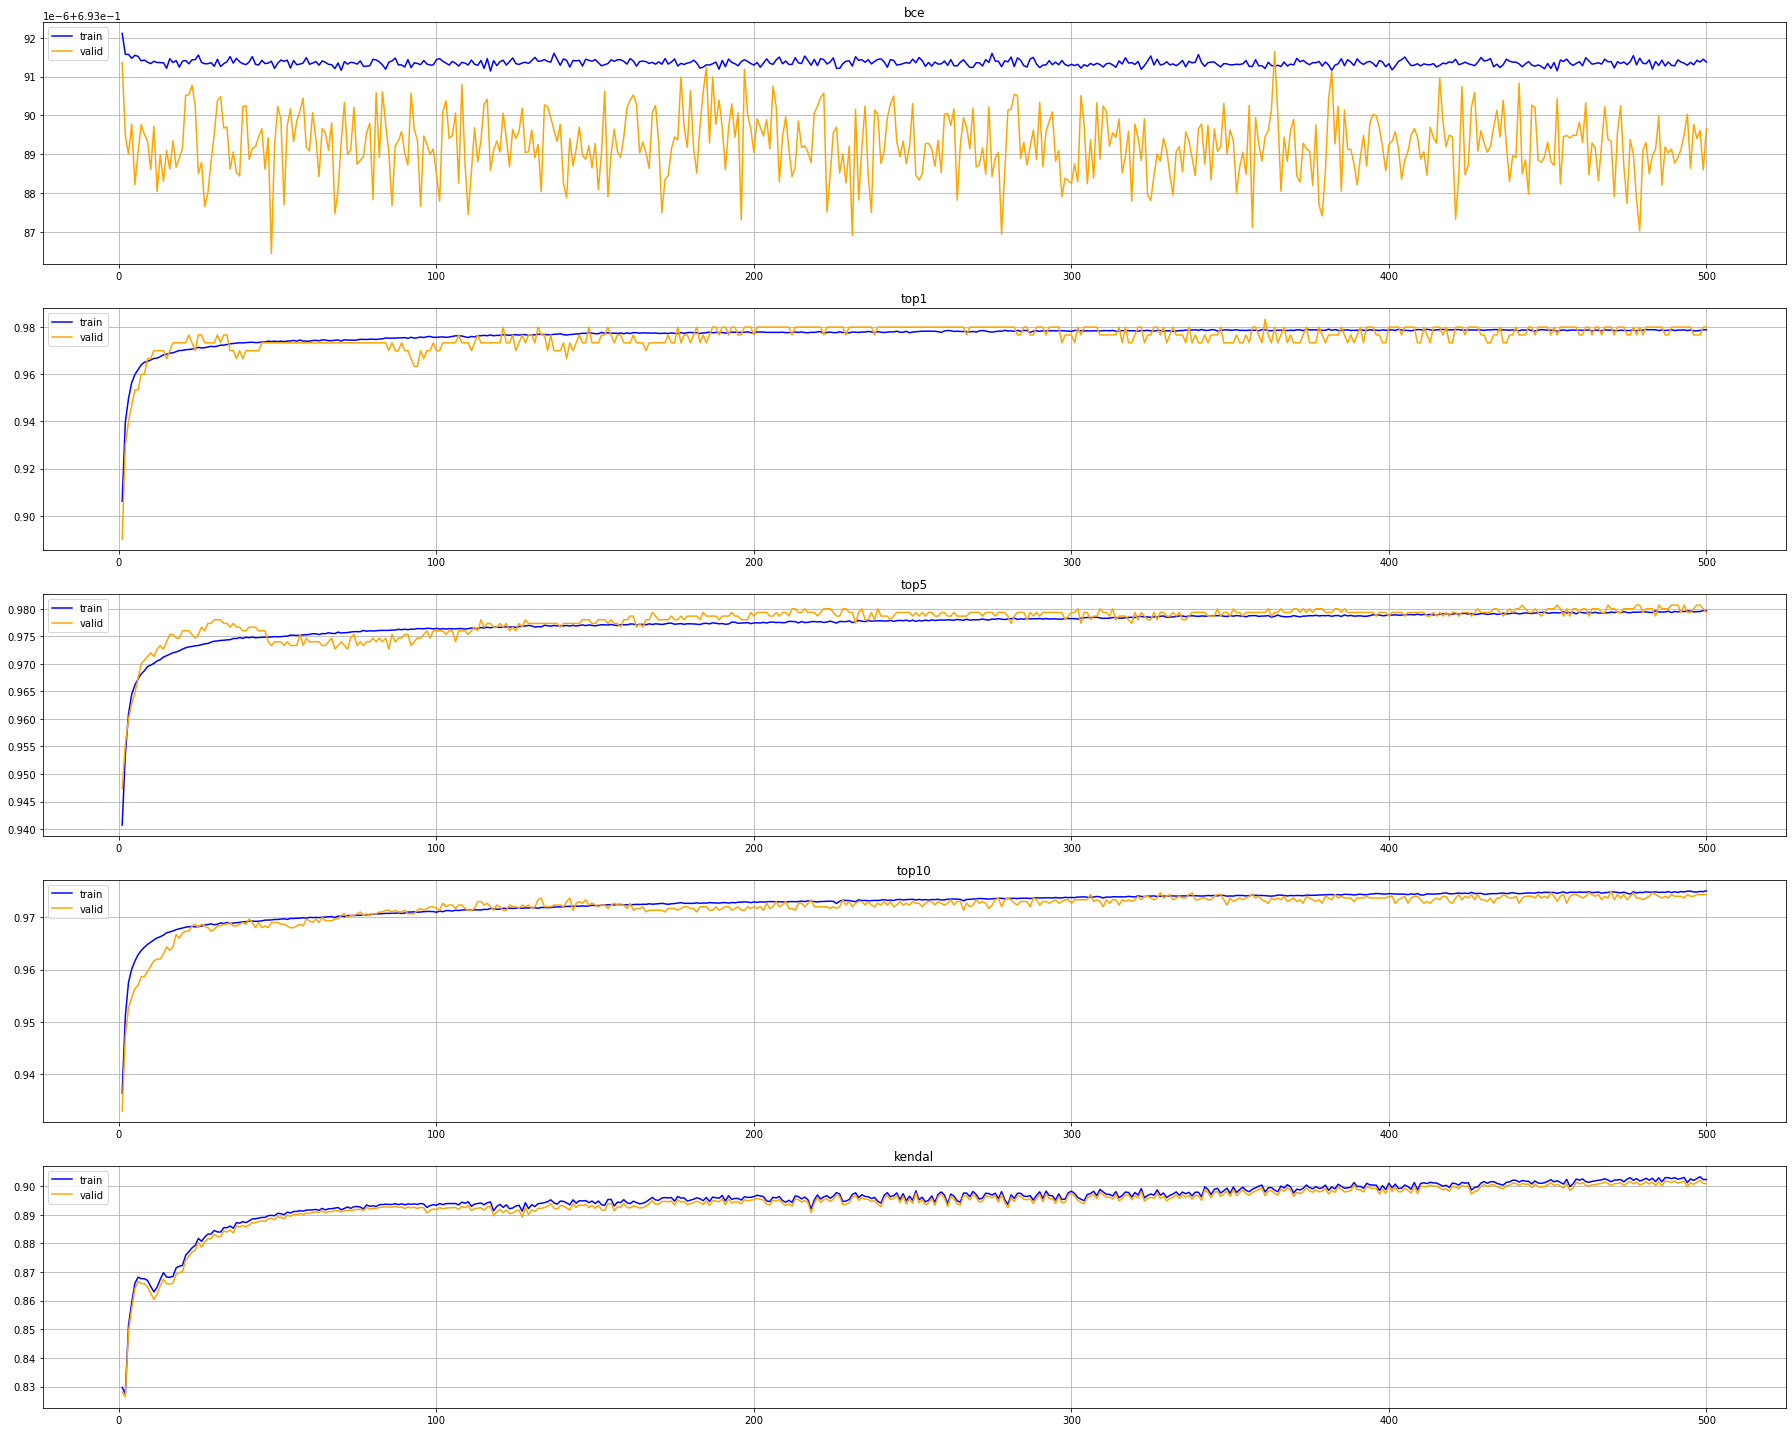

In [39]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, 500, 500)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]

        ax.plot(x, train[key][:500], color="blue")
        ax.plot(x, valid[key][:500], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    

# Baseline

In [ ]:
G_nx = nx.readwrite.edgelist.read_edgelist(synthetic[0], delimiter="\t")
G_nk = nk.nxadapter.nx2nk(G_nx)
G_pyg = from_networkx(G_nx)

In [ ]:
G_nx

In [ ]:
G_nk

In [ ]:
G_pyg

In [ ]:
G_pyg_ = to_data(synthetic[0], between[0])

In [ ]:
G_pyg_.y

In [ ]:
G_nx_ = G_pyg_

## RK (DIAM)

ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [ ]:
ab = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
ab.run()

In [ ]:
ab.scores()

In [ ]:
top_n_percentage(np.array(ab.scores()), G_pyg_.y, k=1)

In [ ]:
kendal_tau_distance(np.array(ab.scores()), G_pyg_.y)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "rk.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.scores()

In [ ]:
top_n_percentage(np.array(kadabra.scores()), G_pyg_.y, k=500)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "kadabra.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

For the value of k, we set it to be 20% of the diameter of the network

In [ ]:
def KbcBetweenness(G, k):
    
    if k < 2:
        k = 2.0
        
    inf = float('inf')

    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0

    return kBC

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    for edge_list, score in zip(synthetic, between):
        
        
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        diameter = nx.algorithms.distance_measures.diameter(G_nx)
        start = time.time()
        result = KbcBetweenness(G_nx, diameter * 0.2)
        end = time.time()
        
        result = [v for k, v in sorted(result.items(), key=lambda  item: int(item[0]), reverse=False)]
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(result), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(result), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(result), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(result), G_pyg.y, k=10))
        
    json.dump(jsn, f)

In [ ]:
G_pyg

## DrBC

In [ ]:
with open(os.path.join(setting.root, "drbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    model.eval()
    model = model.to("cpu")
    for edge_list, score in zip(synthetic, between):
#         G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
#         G_nk = nk.nxadapter.nx2nk(G_nx)
        data = to_data(edge_list, score)
        
        start = time.time()
        bc_pr = model(data)
        end = time.time()

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
        jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
        jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
        jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))
        
    json.dump(jsn, f)

## Node2Vec

# Youtube

In [ ]:
yt_nx = utils.to_networkx(yt_data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)

In [ ]:
yt_nx

In [ ]:
from_networkx(yt_nx)

In [ ]:
with open(os.path.join(setting.root, "youtube.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    yt_pyg = to_data(yt[0], yt_score[0], y_sep=r":")
    yt_nx = utils.to_networkx(yt_pyg, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
    yt_nk = nk.nxadapter.nx2nk(yt_nx)
    
    
    ### RK
    method = nk.centrality.ApproxBetweenness(yt_nk, epsilon=0.1)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nRK")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    ### Kadabra
    method = nk.centrality.KadabraBetweenness(yt_nk, 0.05, 0.8)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nKadabra")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    model.eval()
    start = time.time()
    bc_pr = model(yt_pyg)
    end = time.time()

    print("\nDrBC")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(bc_pr, yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=10)))

        
#     json.dump(jsn, f)

In [ ]:
bc_pr.size()

# Visualize all result

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())

    x = np.linspace(1, 30, 30)

    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        ax.plot(x, rk[key], "o")
        ax.plot(x, kbc[key], "o")
        ax.plot(x, kadabra[key], "o")
        ax.plot(x, drbc[key], "o")
        ax.legend(["rk", "kbc", "kadabra", "drbc"], loc='center right', bbox_to_anchor=(1, 0.5))

        ax.set_xticks(x)
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(os.path.join(setting.root, "synthetic_each.png"), facecolor="white")

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([rk[key], kbc[key], kadabra[key], drbc[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        ### Calculate mean and std
        print("\n{}".format(key))
        rk_ = np.array(rk[key])
        print("RK: mean={}, std={}".format(np.mean(rk_), np.std(rk_)))
        
        kbc_ = np.array(kbc[key])
        print("KBC: mean={}, std={}".format(np.mean(kbc_), np.std(kbc_)))
        
        kadabra_ = np.array(kadabra[key])
        print("KADABRA: mean={}, std={}".format(np.mean(kadabra_), np.std(kadabra_)))
        
        drbc_ = np.array(drbc[key])
        print("DrBC: mean={}, std={}".format(np.mean(drbc_), np.std(drbc_)))
        
    
    plt.setp(axs,  xticklabels=['rk', 'kbc', 'kadabra', "drbc"])
    plt.savefig(os.path.join(setting.root, "synthetic_box.png"), facecolor="white")
    
    